Please run those two cells before running the Notebook!

As those plotting settings are standard throughout the book, we do not show them in the book every time we plot something.

In [5]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [6]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from statsmodels.graphics.tsaplots import plot_acf
import warnings

# Установка стилей
sns.set_theme(context="talk", style="whitegrid",
              palette="colorblind", color_codes=True,
              rc={"figure.figsize": [12, 8]})

# Игнорирование предупреждений (новый способ для pandas 2.0+)
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=pd.errors.SettingWithCopyWarning)

# Chapter 6 - Time Series Analysis and Forecasting

## 6.1 Time series decomposition

### How to do it...

In [7]:
pip install nasdaq-data-link

1. Import the libraries and authenticate:

In [8]:
from google.colab import userdata
api = userdata.get('api_meri')

In [9]:
import pandas as pd
import nasdaqdatalink
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

nasdaqdatalink.ApiConfig.api_key = api

2. Download the monthly US unemployment rate from years 2010-2019:

In [15]:
import pandas as pd
import pandas_datareader as pdr
from datetime import datetime

# Download data from FRED
df = pdr.get_data_fred('UNRATENSA', start=datetime(2010, 1, 1), end=datetime(2019, 12, 31))
df = df.rename(columns={'UNRATENSA': 'unemp_rate'})
df.head()

unemp_rate
DATE                  
2010-01-01        10.6
2010-02-01        10.4
2010-03-01        10.2
2010-04-01         9.5
2010-05-01         9.3

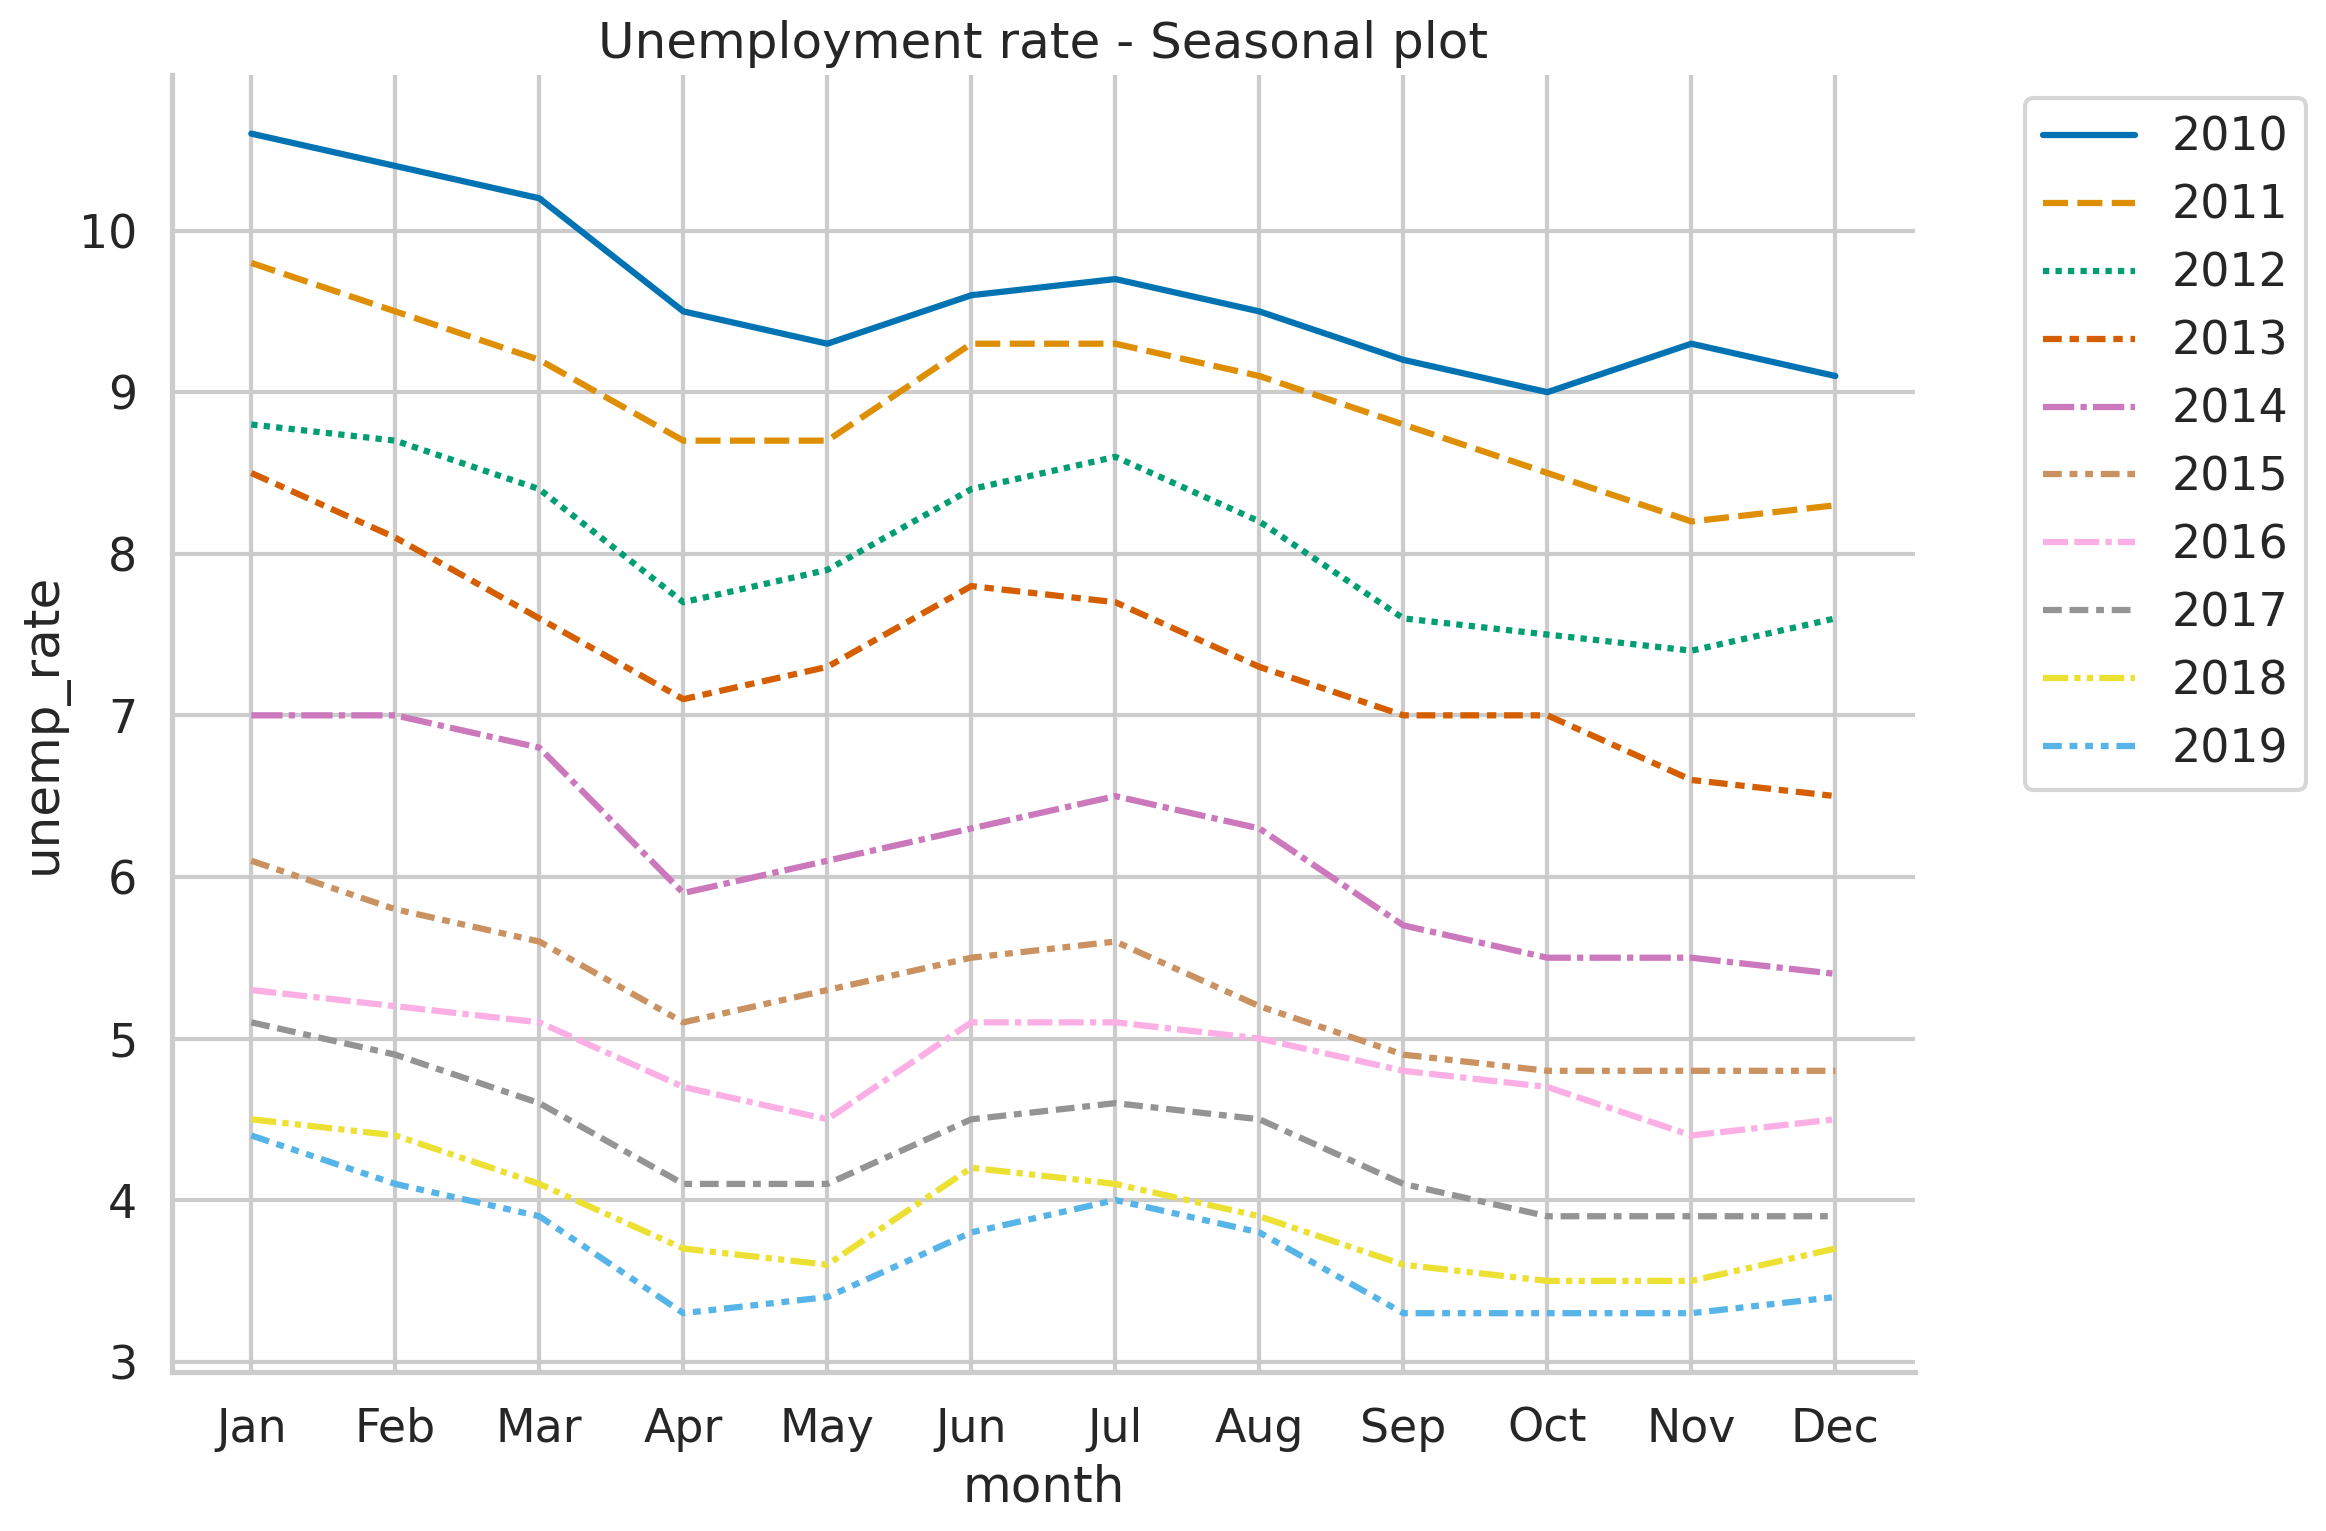

In [16]:
# a quick look at the plot
temp_df = df.copy()

temp_df["year"] = temp_df.index.year
temp_df["month"] = temp_df.index.strftime("%b")

sns.lineplot(data=temp_df,
             x="month",
             y="unemp_rate",
             hue="year",
             style="year",
             legend="full",
             palette="colorblind")

plt.title("Unemployment rate - Seasonal plot")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2);

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_6_2", dpi=200)

3. Add rolling mean and standard deviation:

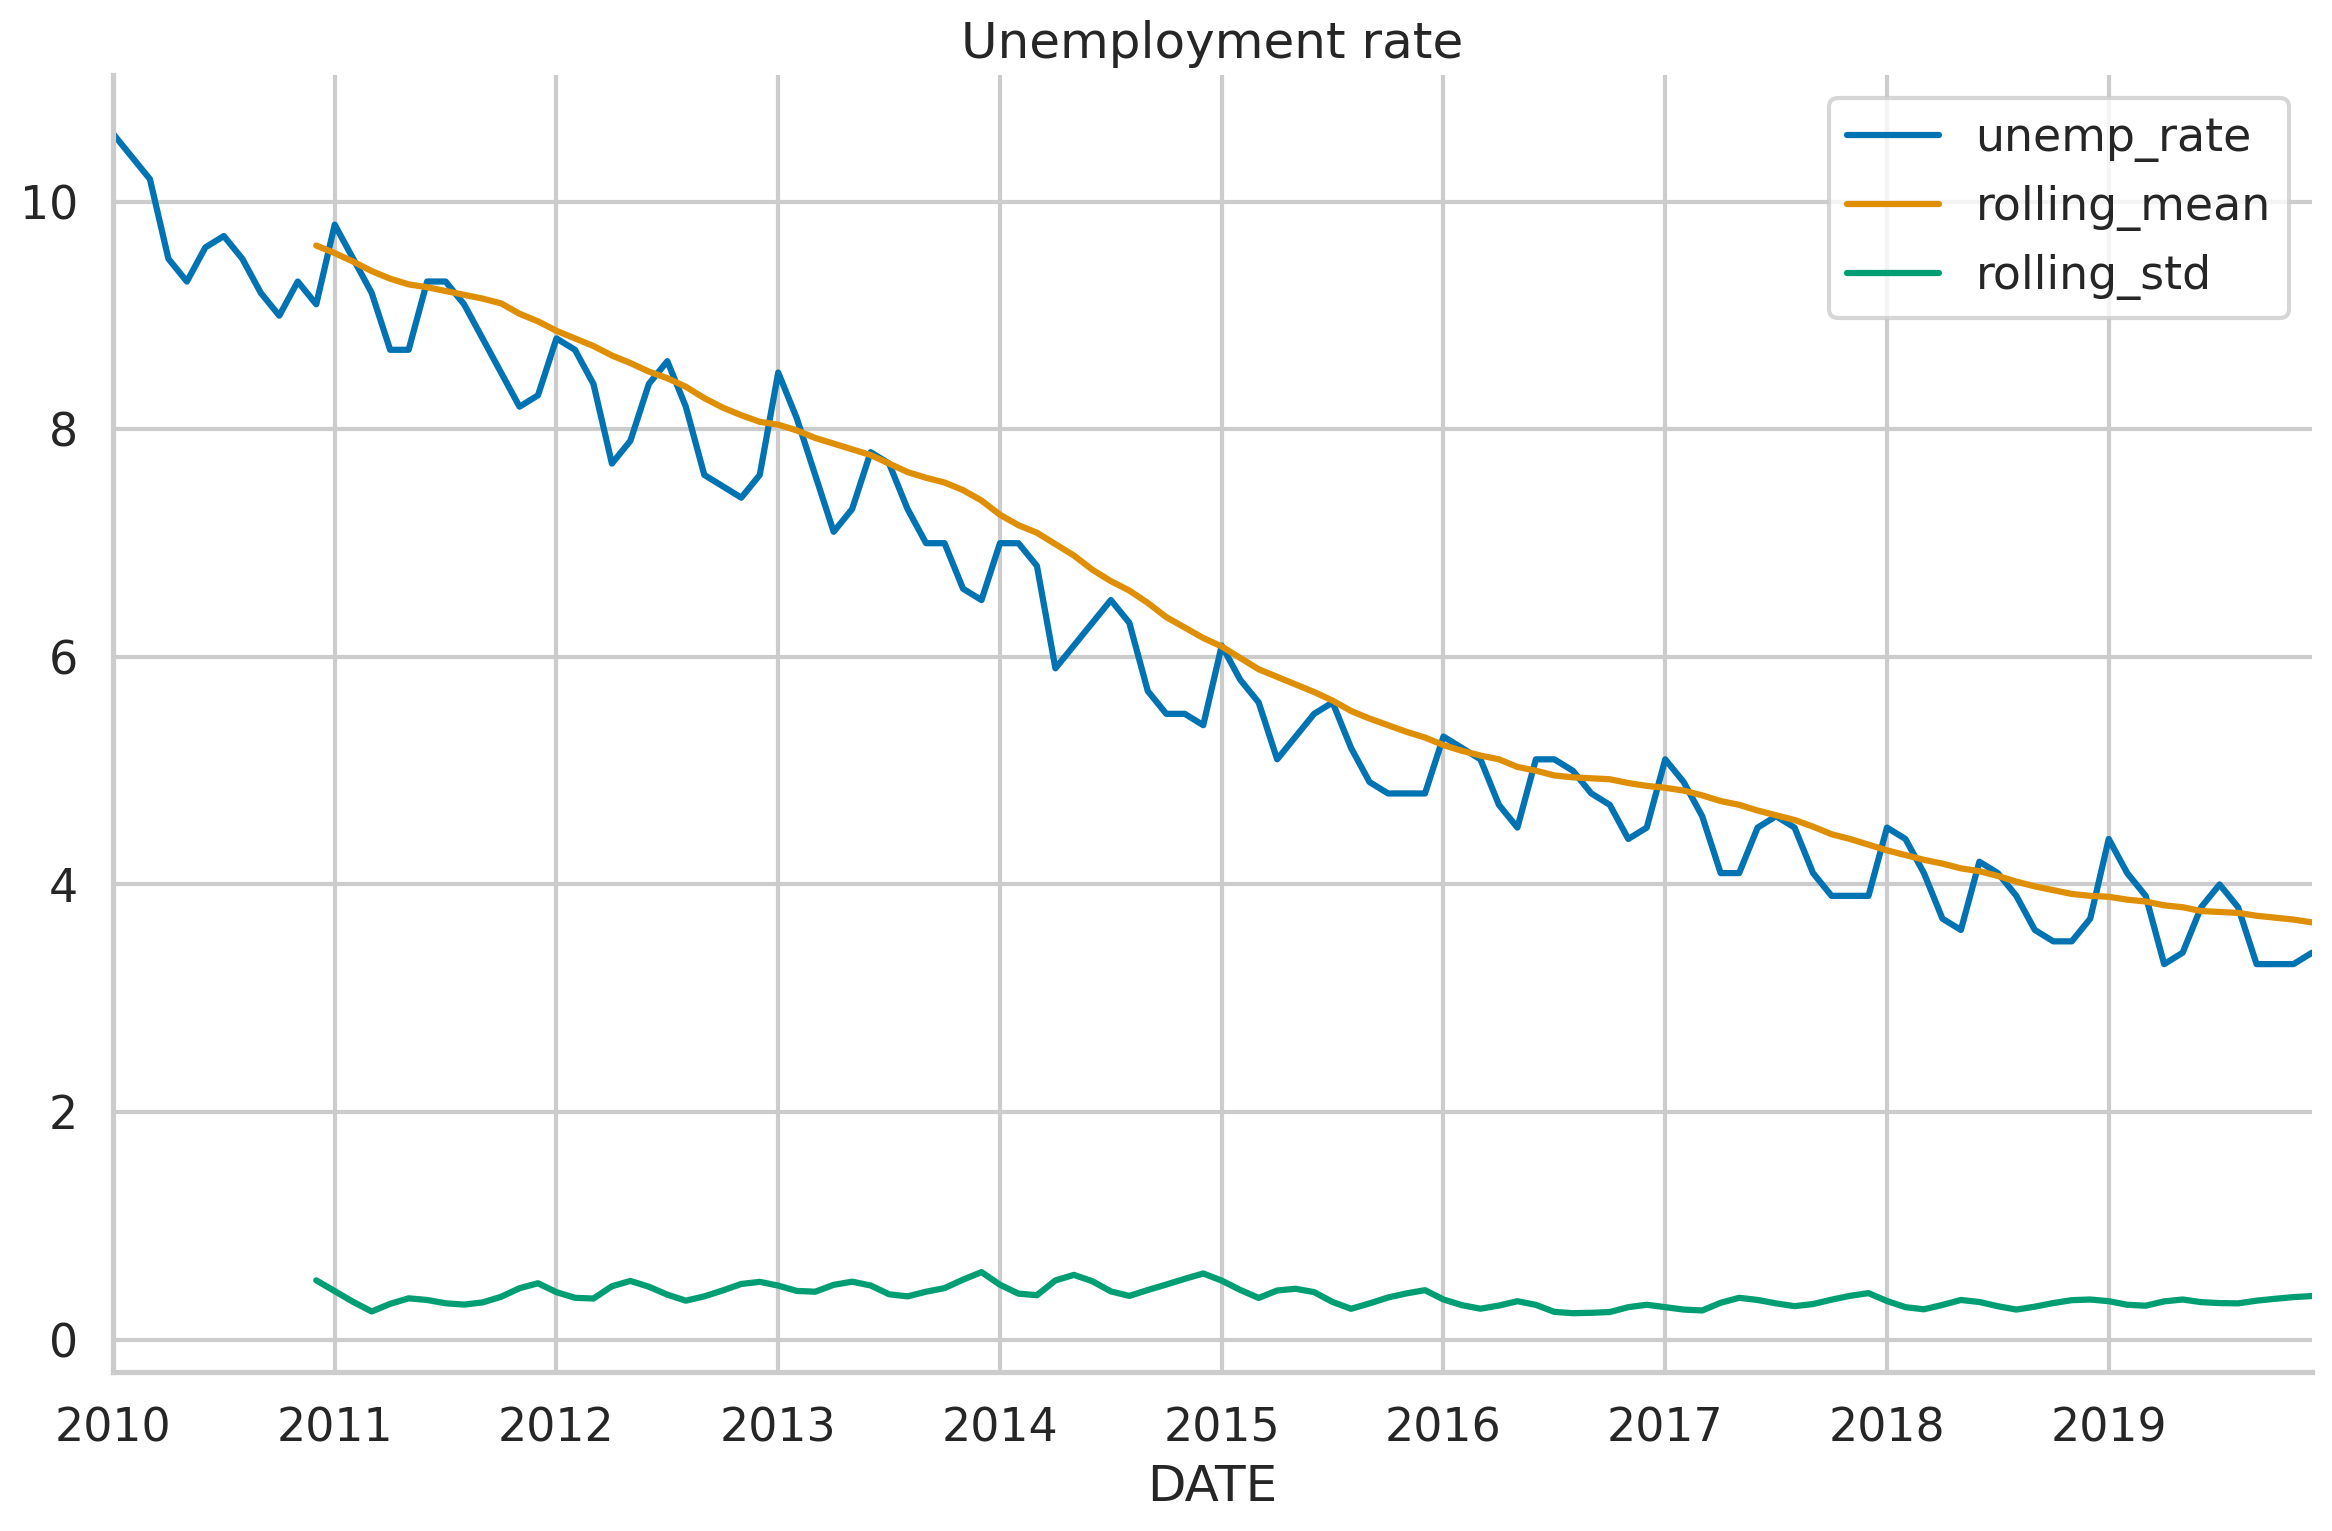

In [17]:
WINDOW_SIZE = 12
df["rolling_mean"] = df["unemp_rate"].rolling(window=WINDOW_SIZE).mean()
df["rolling_std"] = df["unemp_rate"].rolling(window=WINDOW_SIZE).std()
df.plot(title="Unemployment rate")

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_6_3", dpi=200)

4. Carry out seasonal decomposition using the additive model:

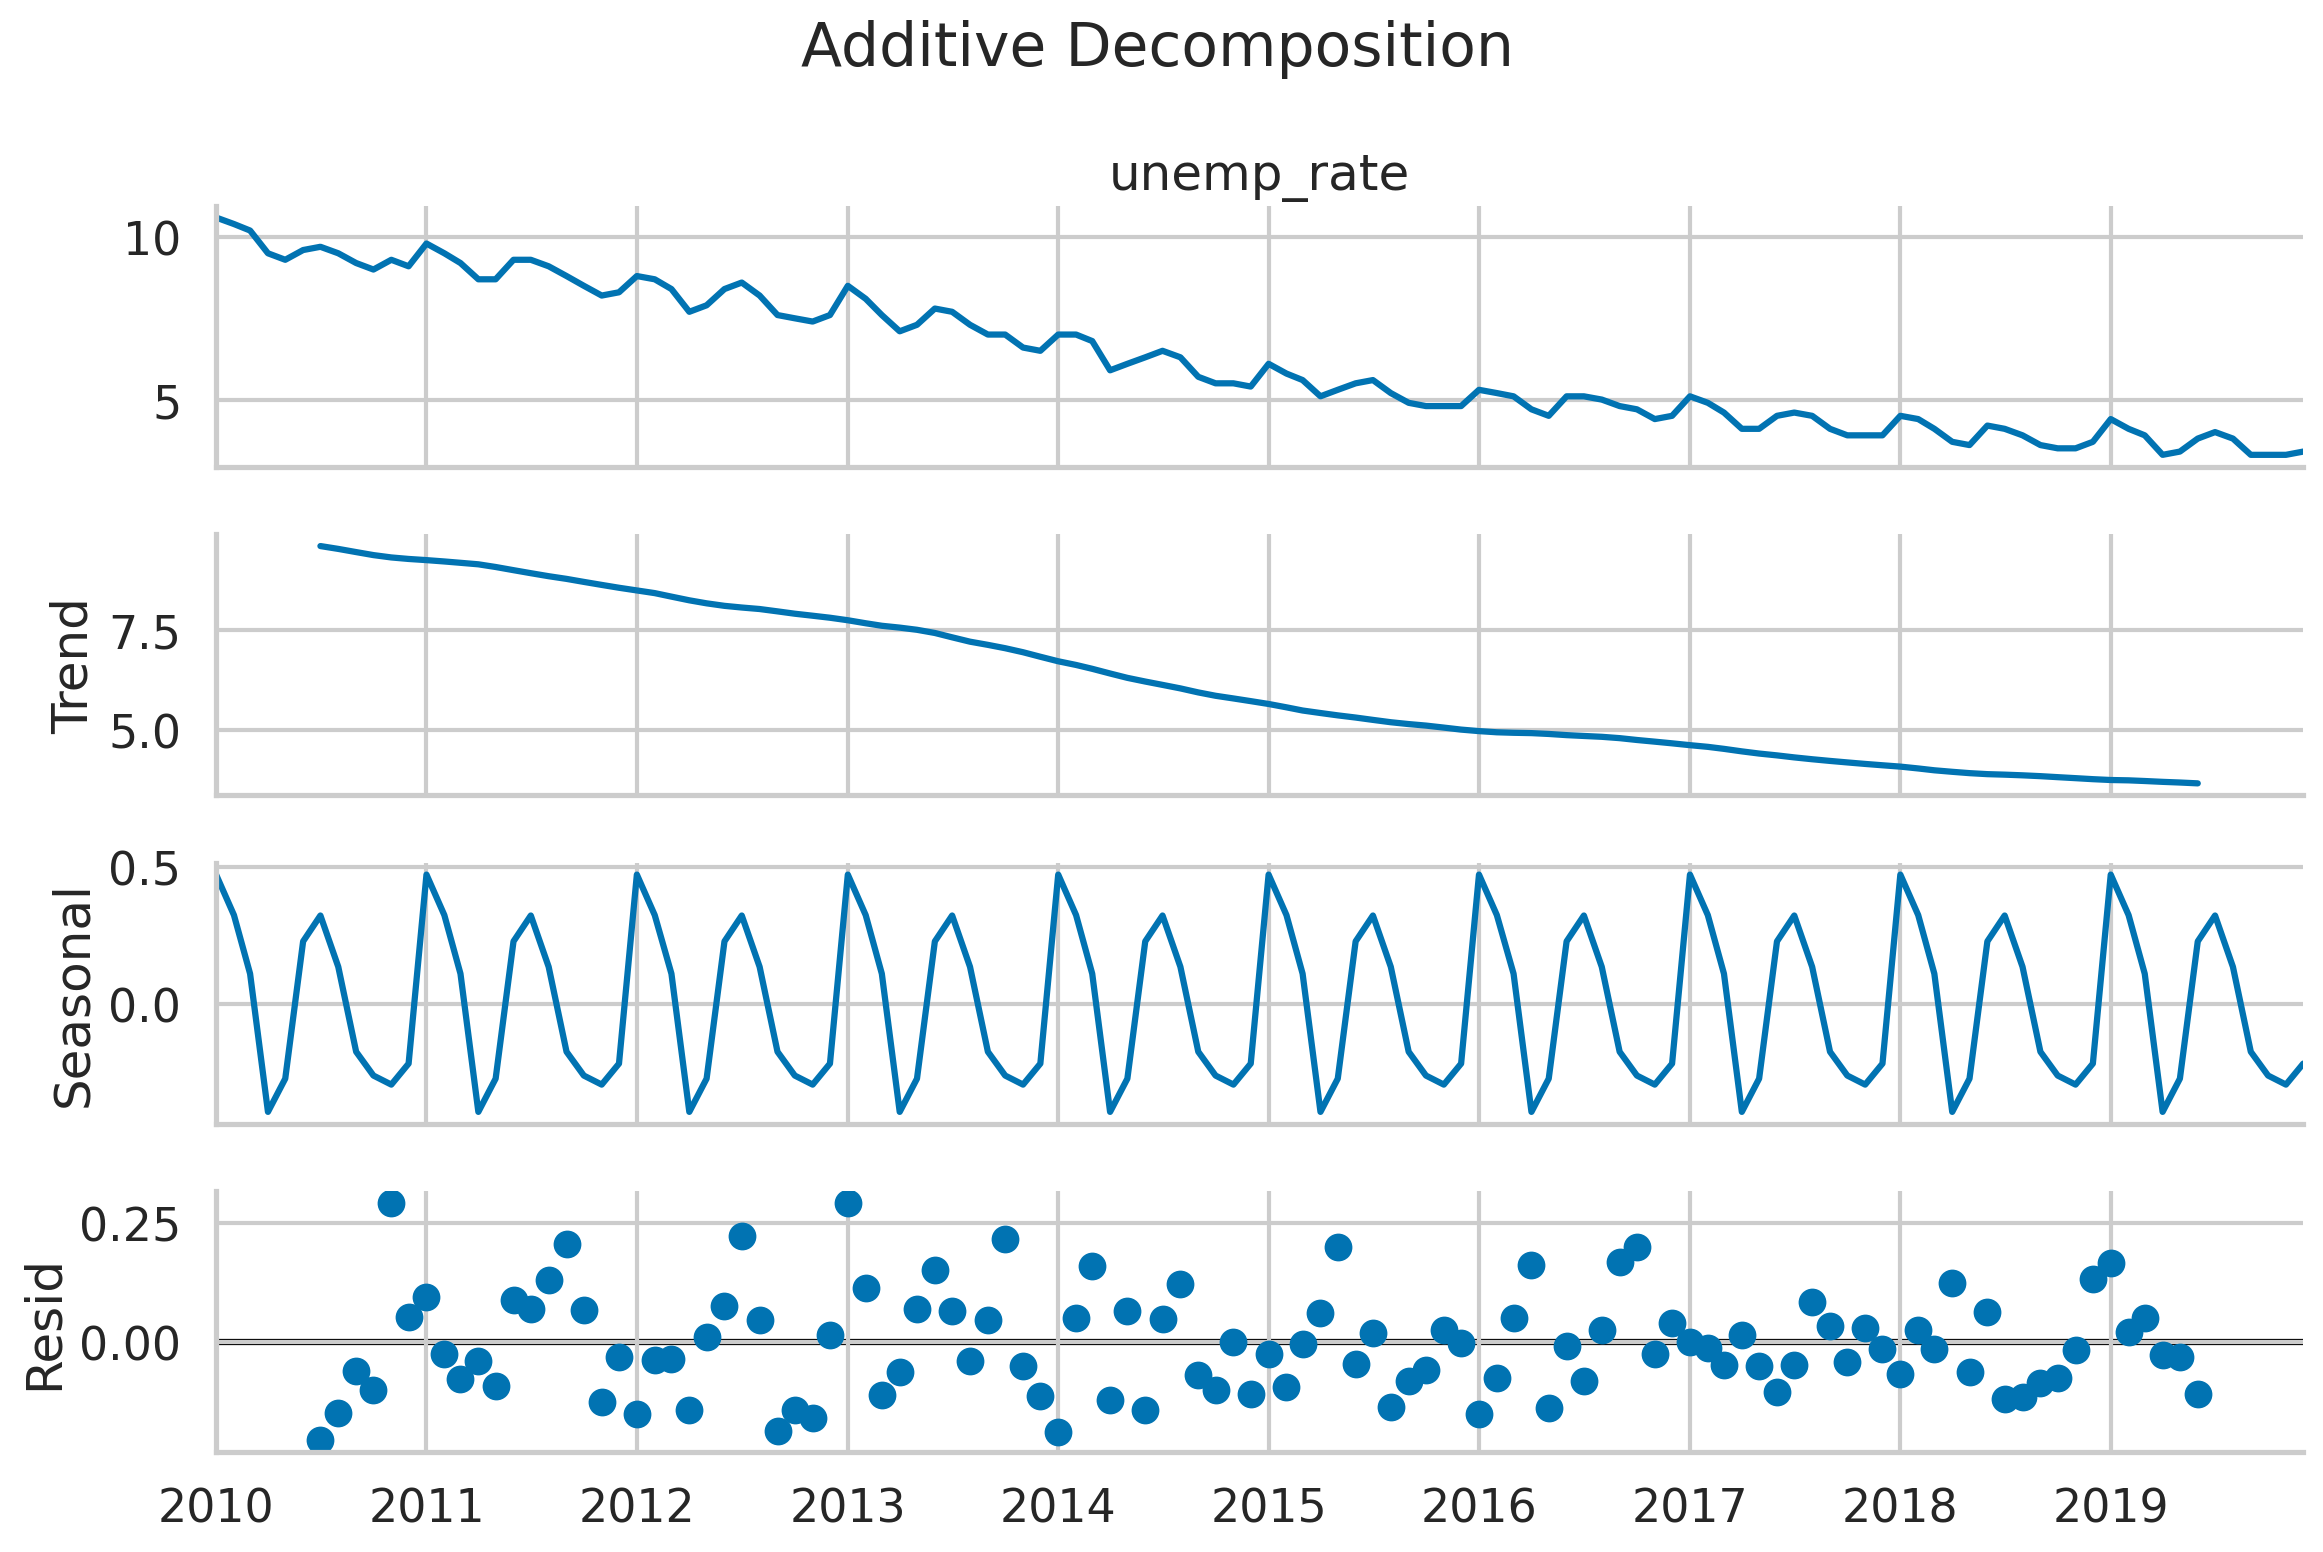

In [18]:
decomposition_results = seasonal_decompose(df["unemp_rate"],
                                           model="additive")
(
    decomposition_results
    .plot()
    .suptitle("Additive Decomposition")
)

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_6_4", dpi=200)

Use the STL decomposition:

## Задание 1.
Выполнить моделирование данных по стоимости акций компаний Apple воспользовавшись данными Yahoo: `df = yf.download("AAPL", start="2020-01-01", end="2022-12-31",progress=False)`. Используйте модель `seasonal_decompose` с разными типами параметра `model`.

In [19]:
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Загрузка данных по акциям Apple (AAPL)
df = yf.download("AAPL", start="2020-01-01", end="2022-12-31", progress=False)

# Оставим только столбец с ценой закрытия ('Close')
df = df[['Close']].rename(columns={'Close': 'Price'})
df.head()

Price           Price
Ticker           AAPL
Date                 
2020-01-02  72.716057
2020-01-03  72.009132
2020-01-06  72.582909
2020-01-07  72.241547
2020-01-08  73.403641

<Figure size 1200x800 with 0 Axes>

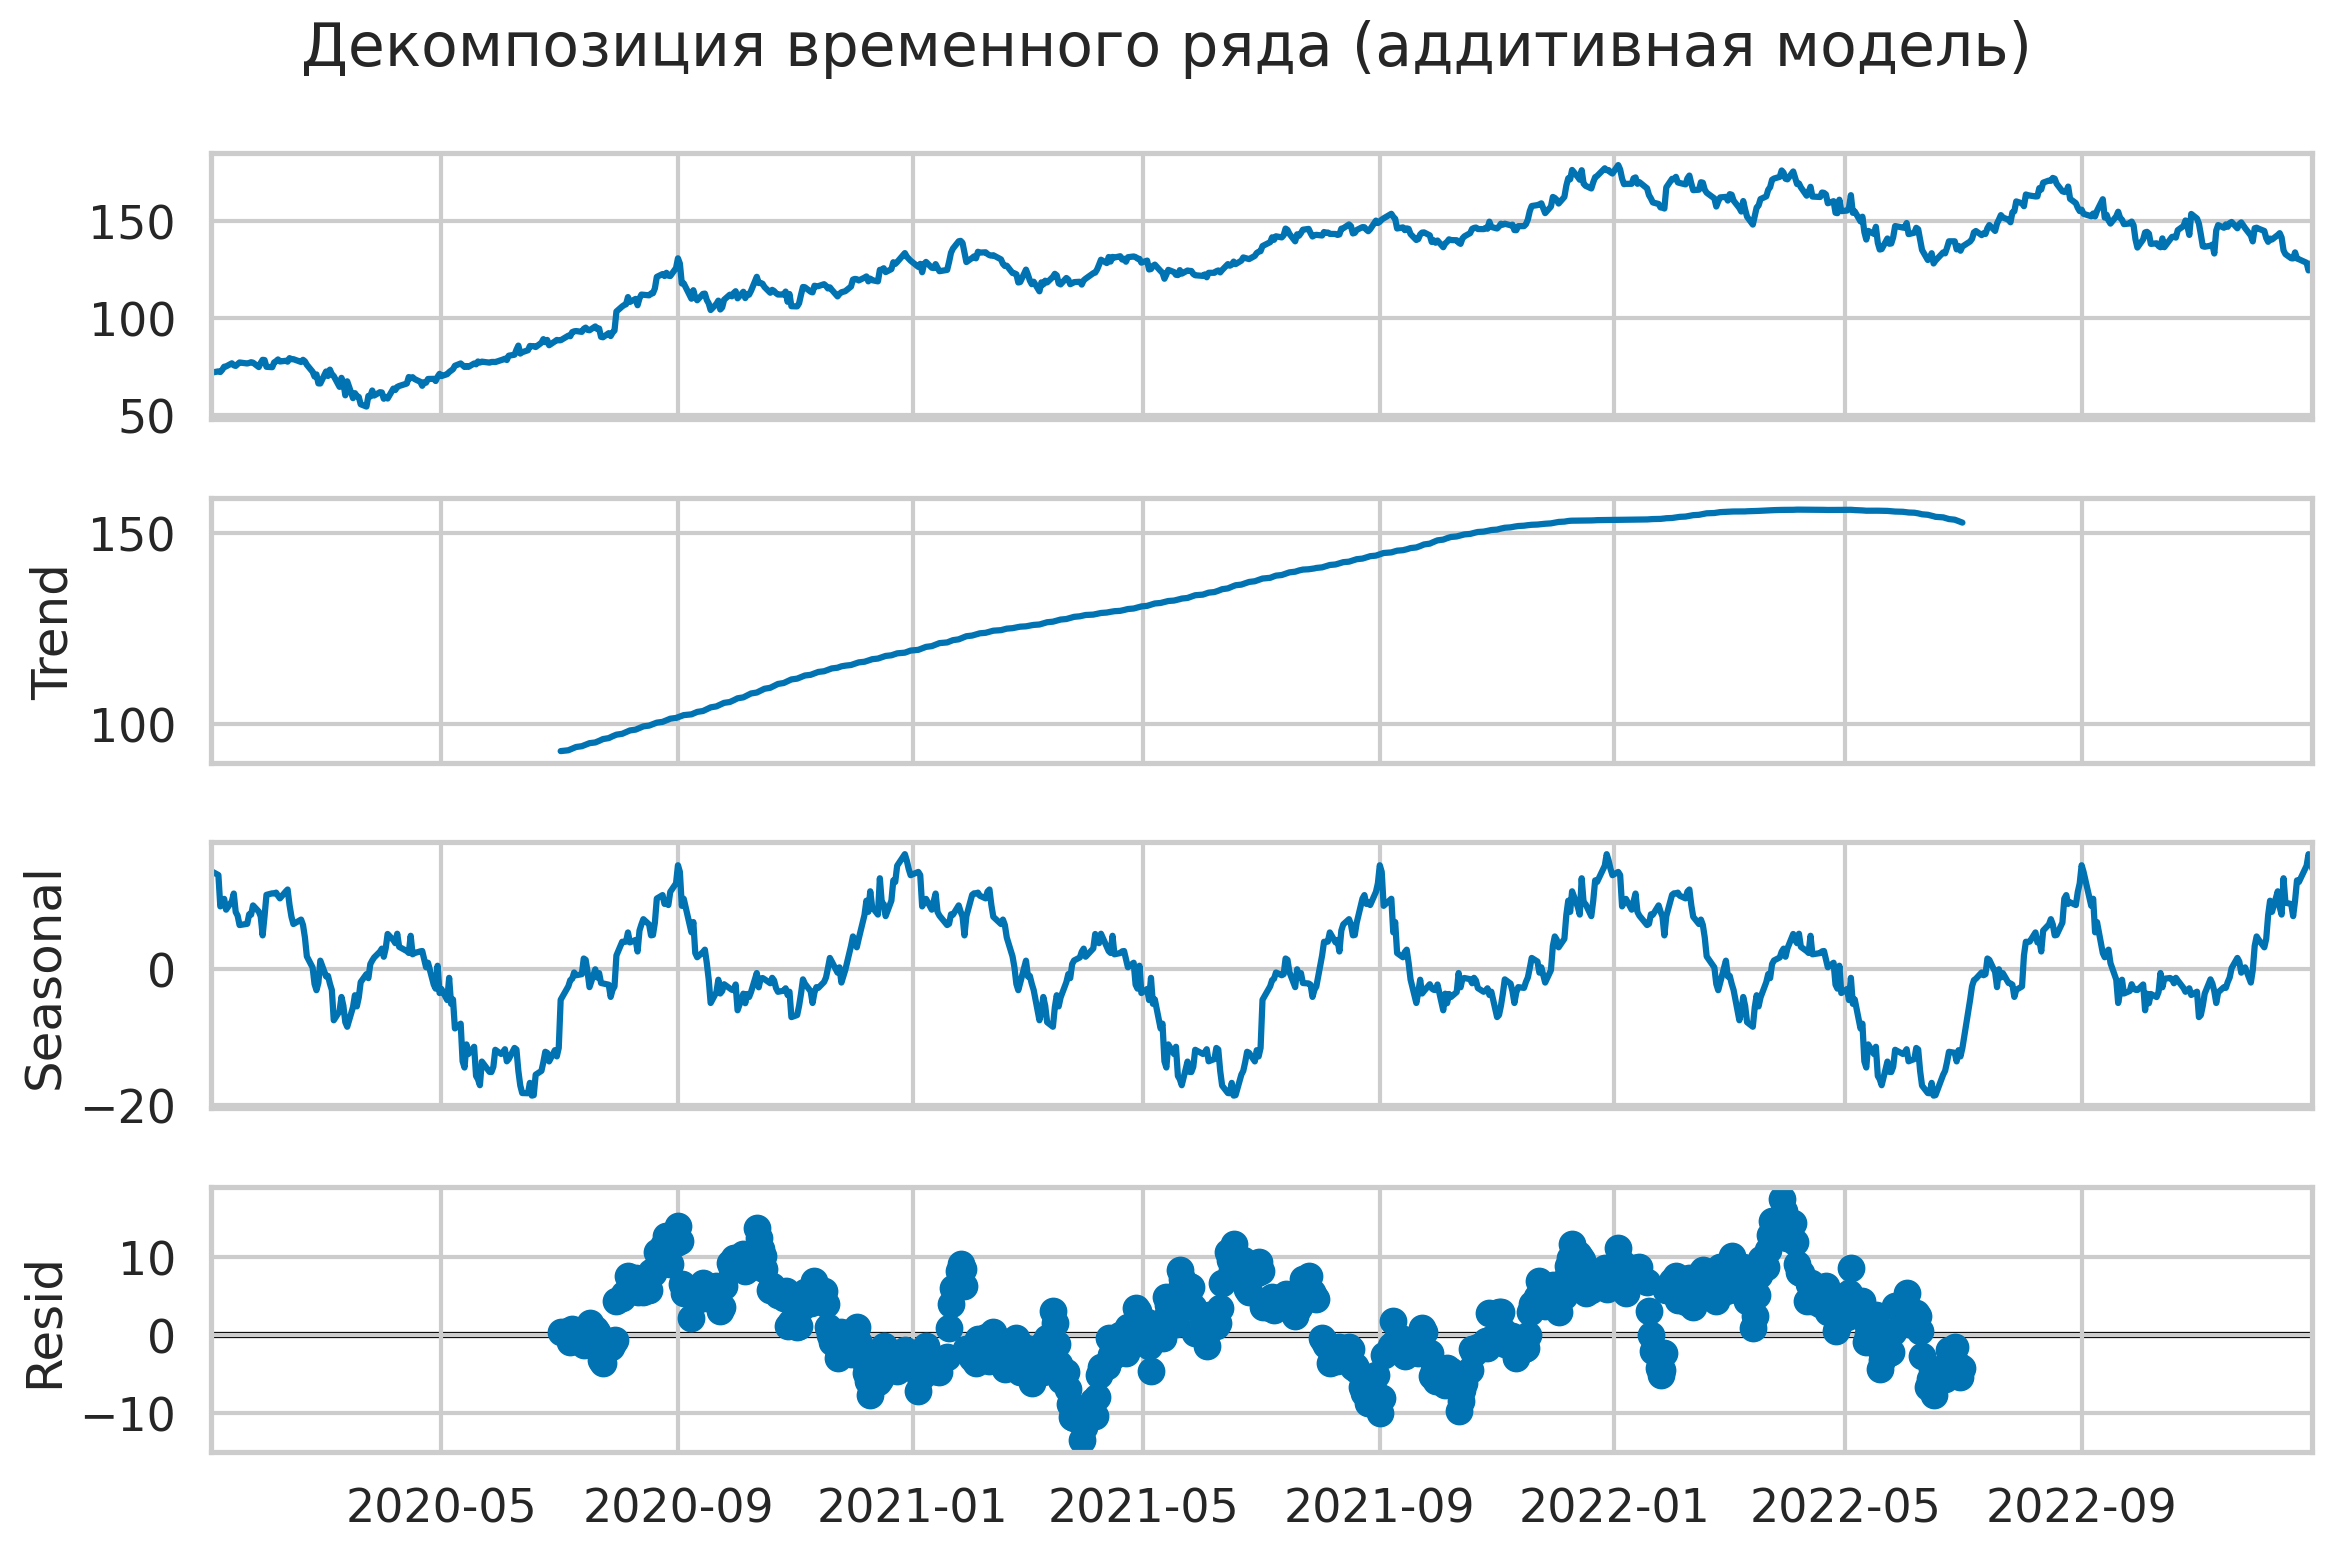

In [20]:
# Аддитивная модель (model='additive')
result_add = seasonal_decompose(df['Price'], model='additive', period=252)  # 252 торговых дня в году

# Визуализация декомпозиции
plt.figure(figsize=(12, 8))
result_add.plot()
plt.suptitle('Декомпозиция временного ряда (аддитивная модель)')
plt.tight_layout()
plt.show()

<Figure size 1200x800 with 0 Axes>

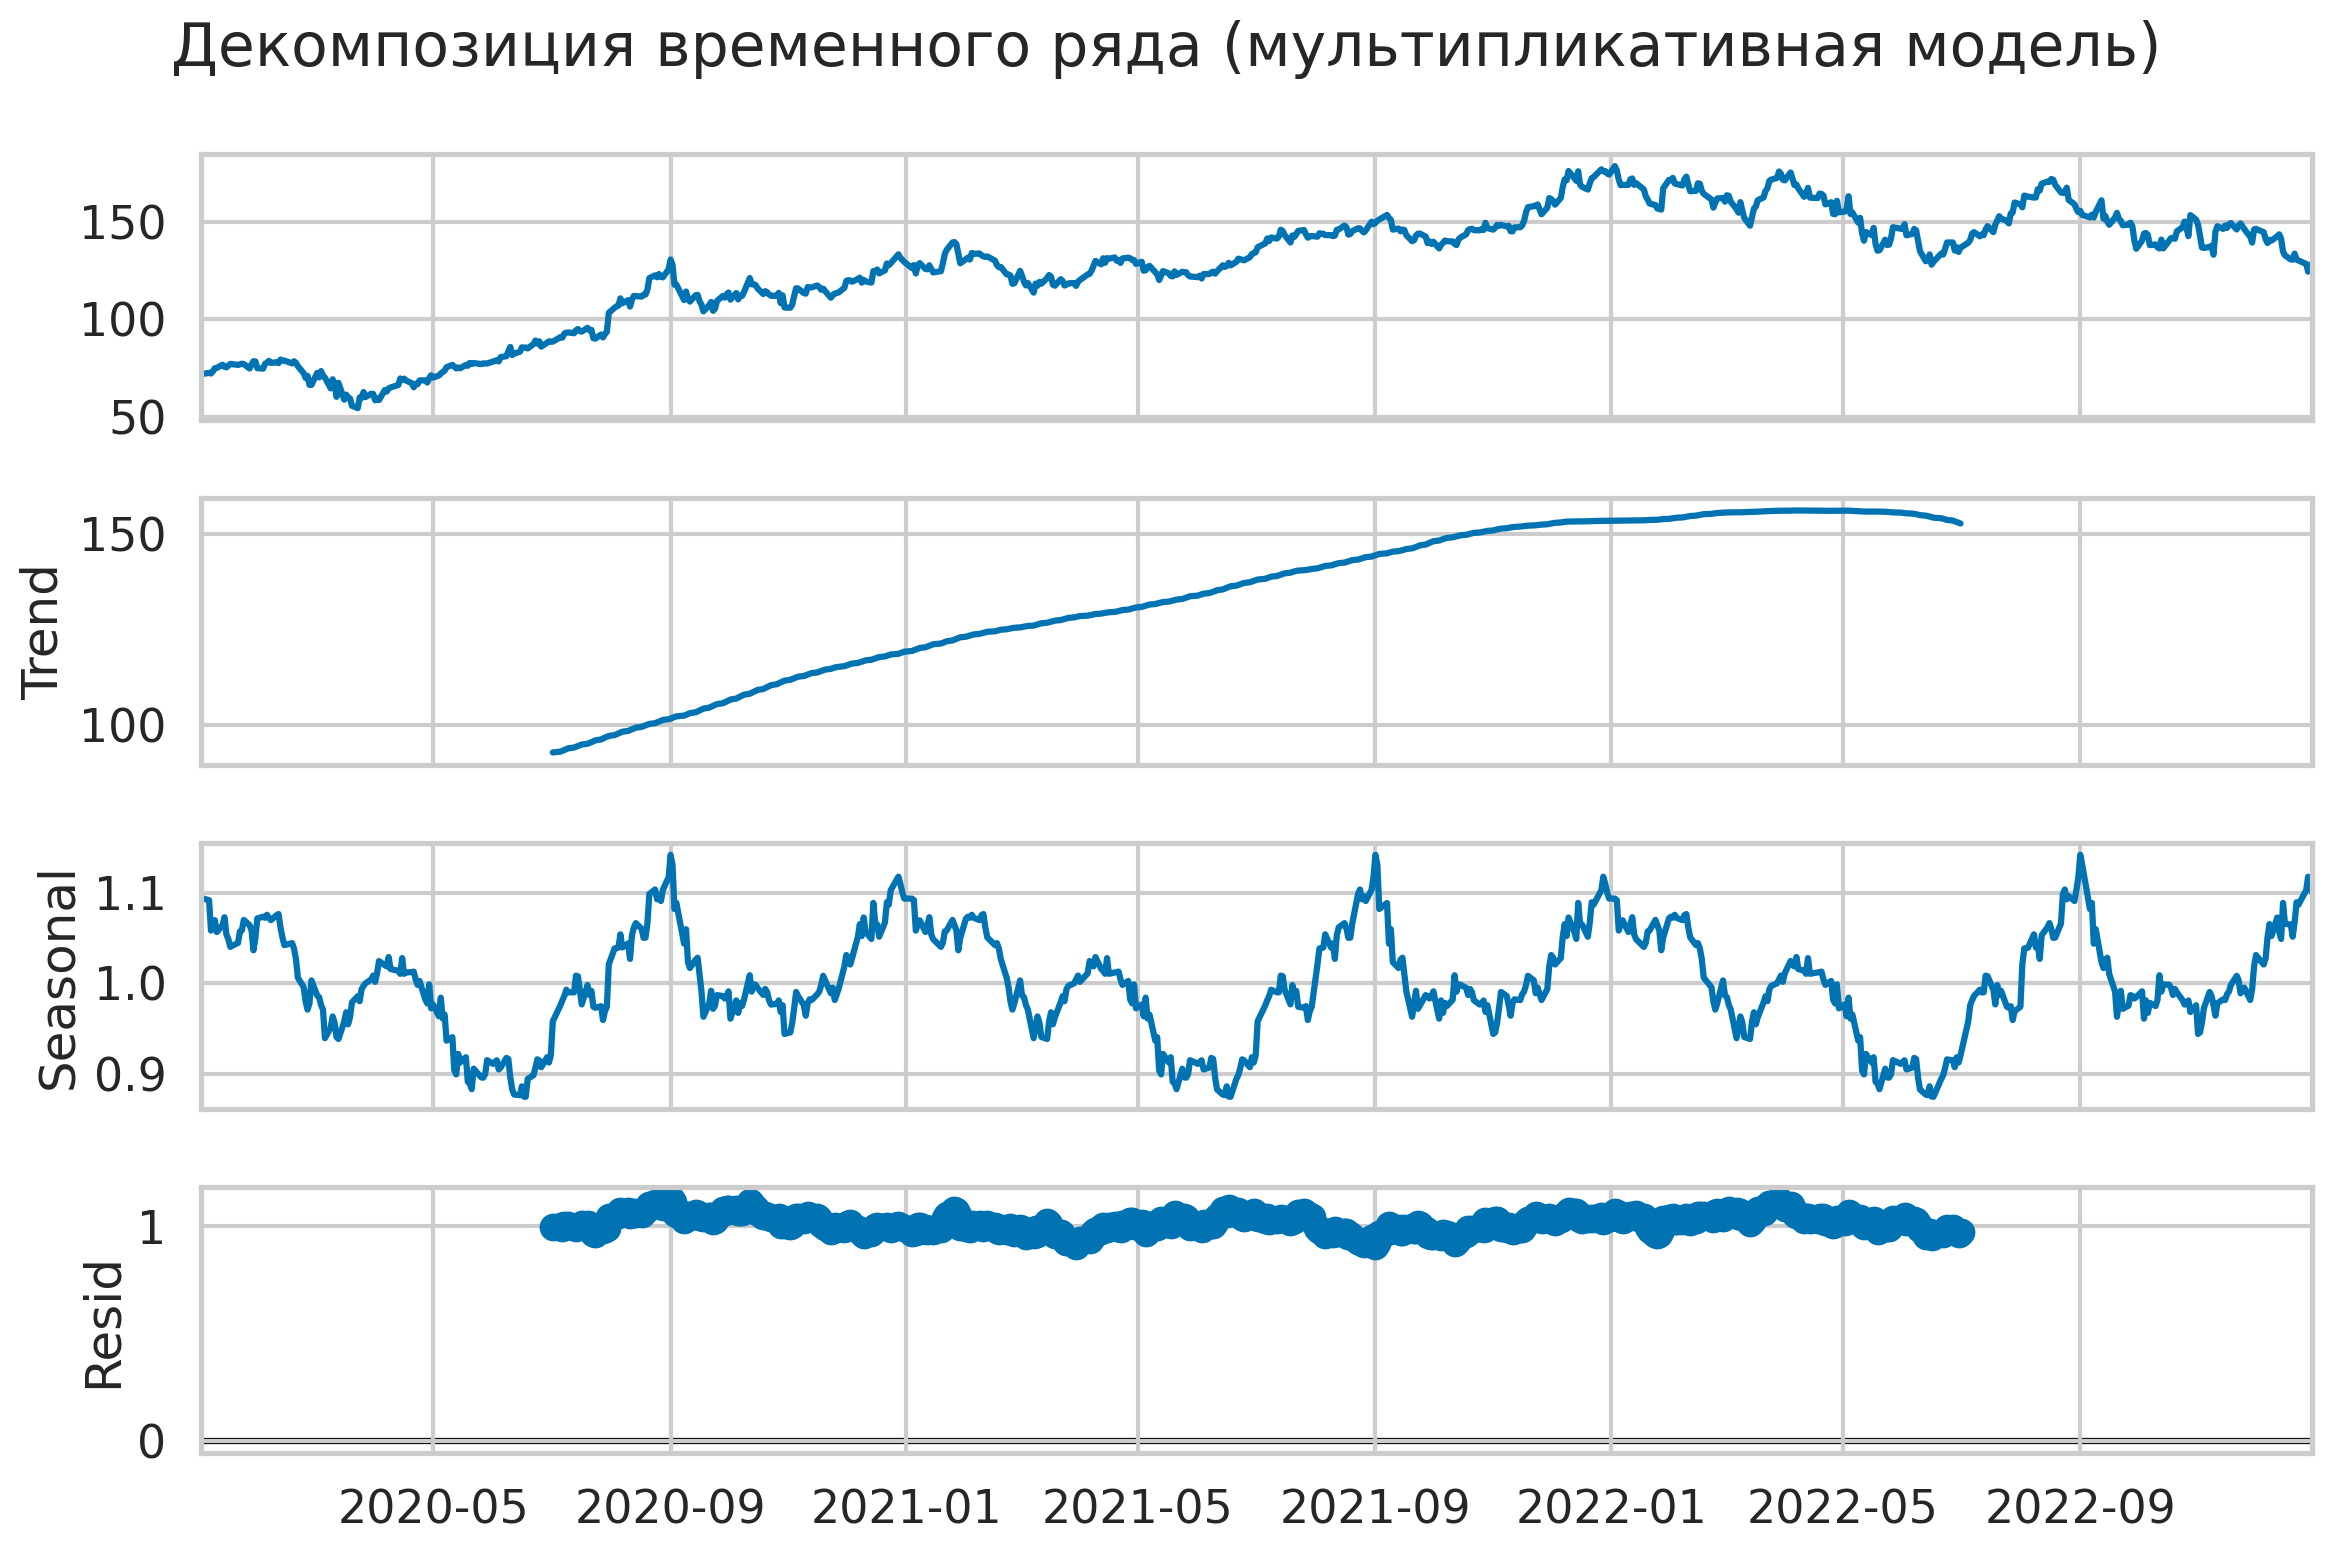

In [21]:
# Мультипликативная модель (model='multiplicative')
result_mul = seasonal_decompose(df['Price'], model='multiplicative', period=252)

# Визуализация декомпозиции
plt.figure(figsize=(12, 8))
result_mul.plot()
plt.suptitle('Декомпозиция временного ряда (мультипликативная модель)')
plt.tight_layout()
plt.show()

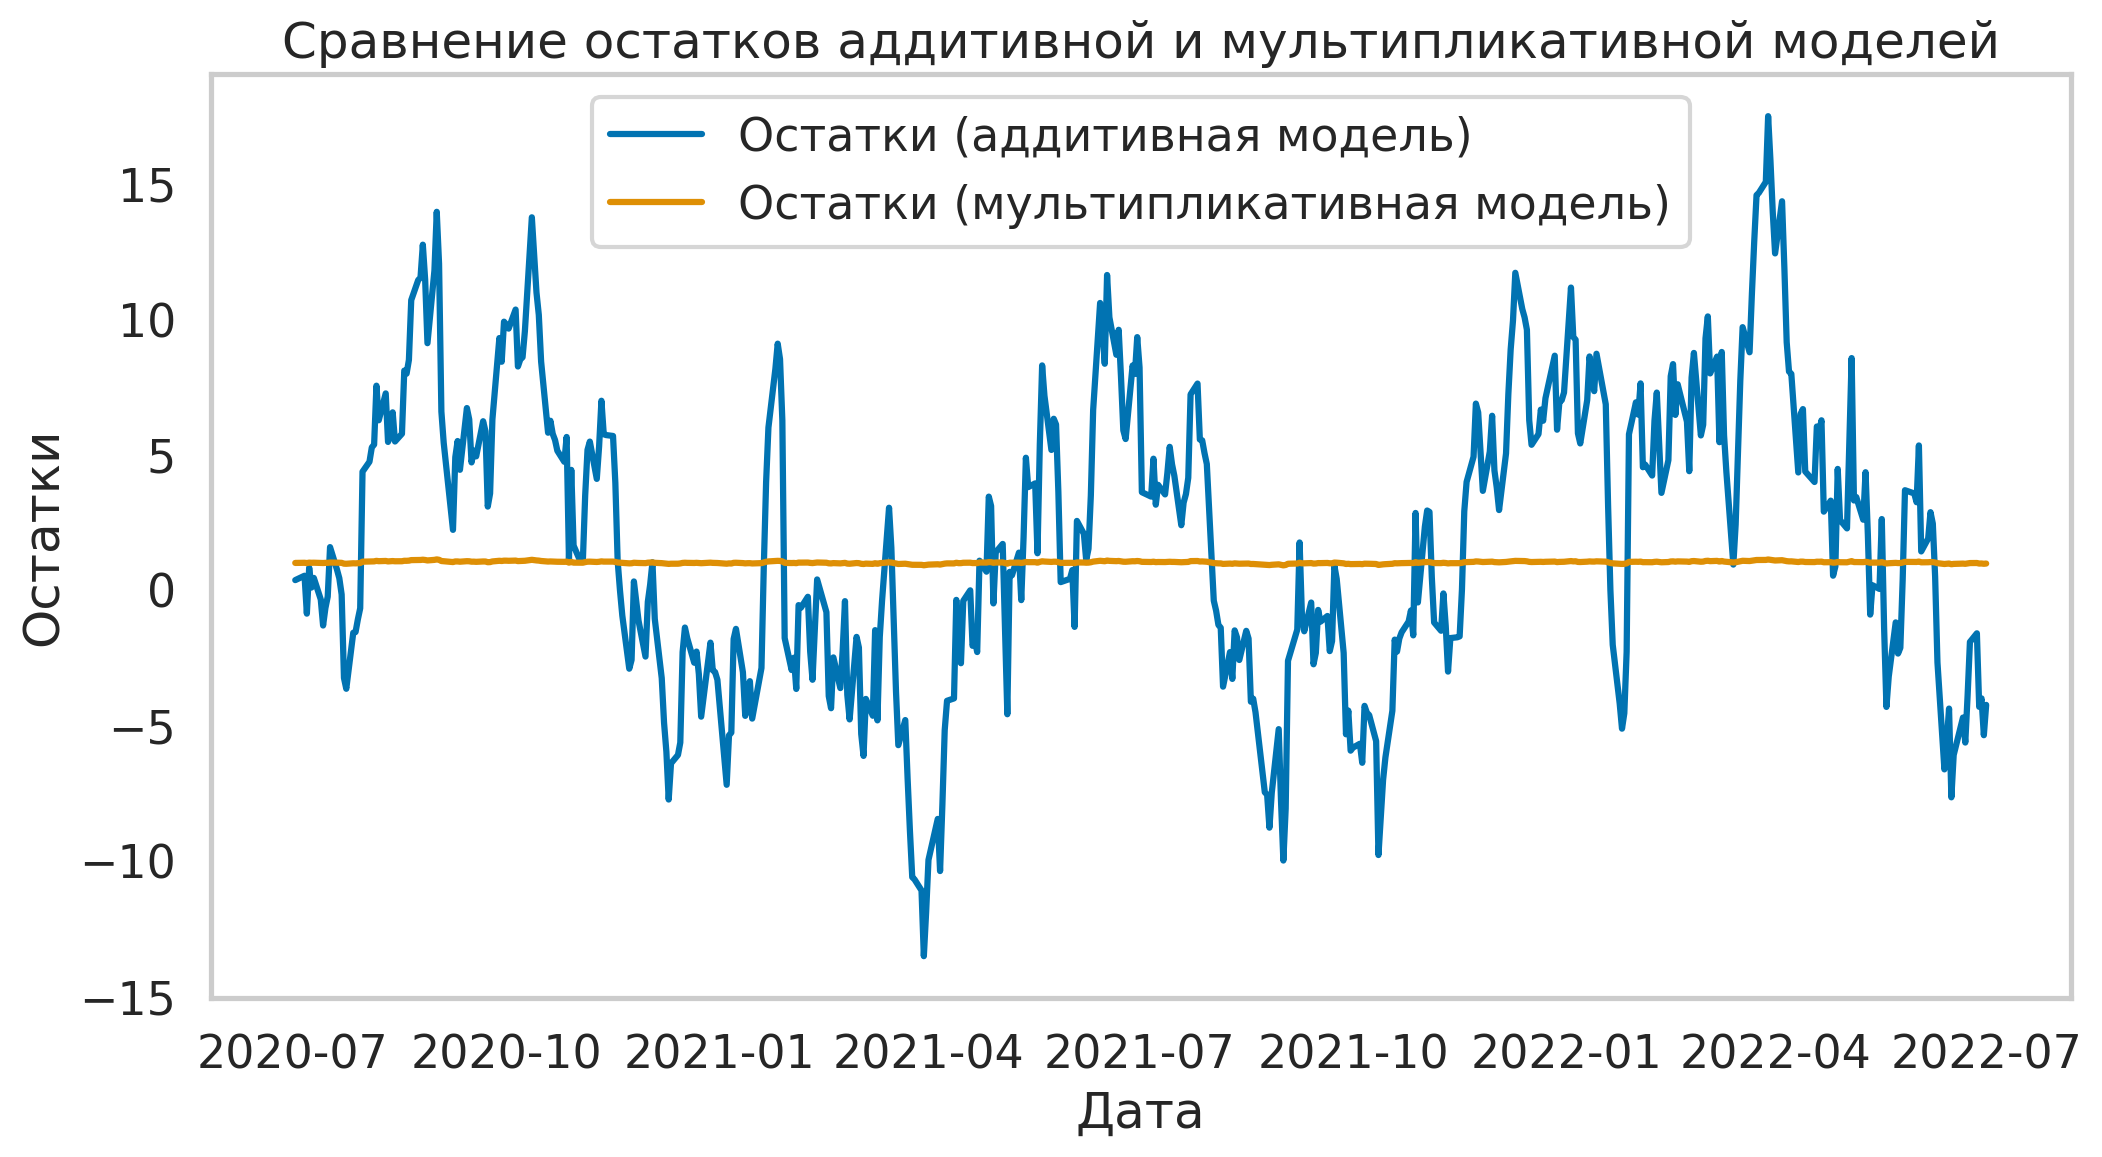

In [22]:
# Сравнение остатков двух моделей
plt.figure(figsize=(12, 6))
plt.plot(result_add.resid, label='Остатки (аддитивная модель)')
plt.plot(result_mul.resid, label='Остатки (мультипликативная модель)')
plt.title('Сравнение остатков аддитивной и мультипликативной моделей')
plt.xlabel('Дата')
plt.ylabel('Остатки')
plt.legend()
plt.grid()
plt.show()

Compare the decompositions with and without the robust setting:

## Задание 2.
Выполнить моделирование данных по стоимости акций компаний Apple воспользовавшись данными Yahoo: `df = yf.download("AAPL", start="2020-01-01", end="2022-12-31",progress=False)`. Используйте модель STL декомпозиции с включенным и выключенным параметром `robust`. Сравните данные графически.

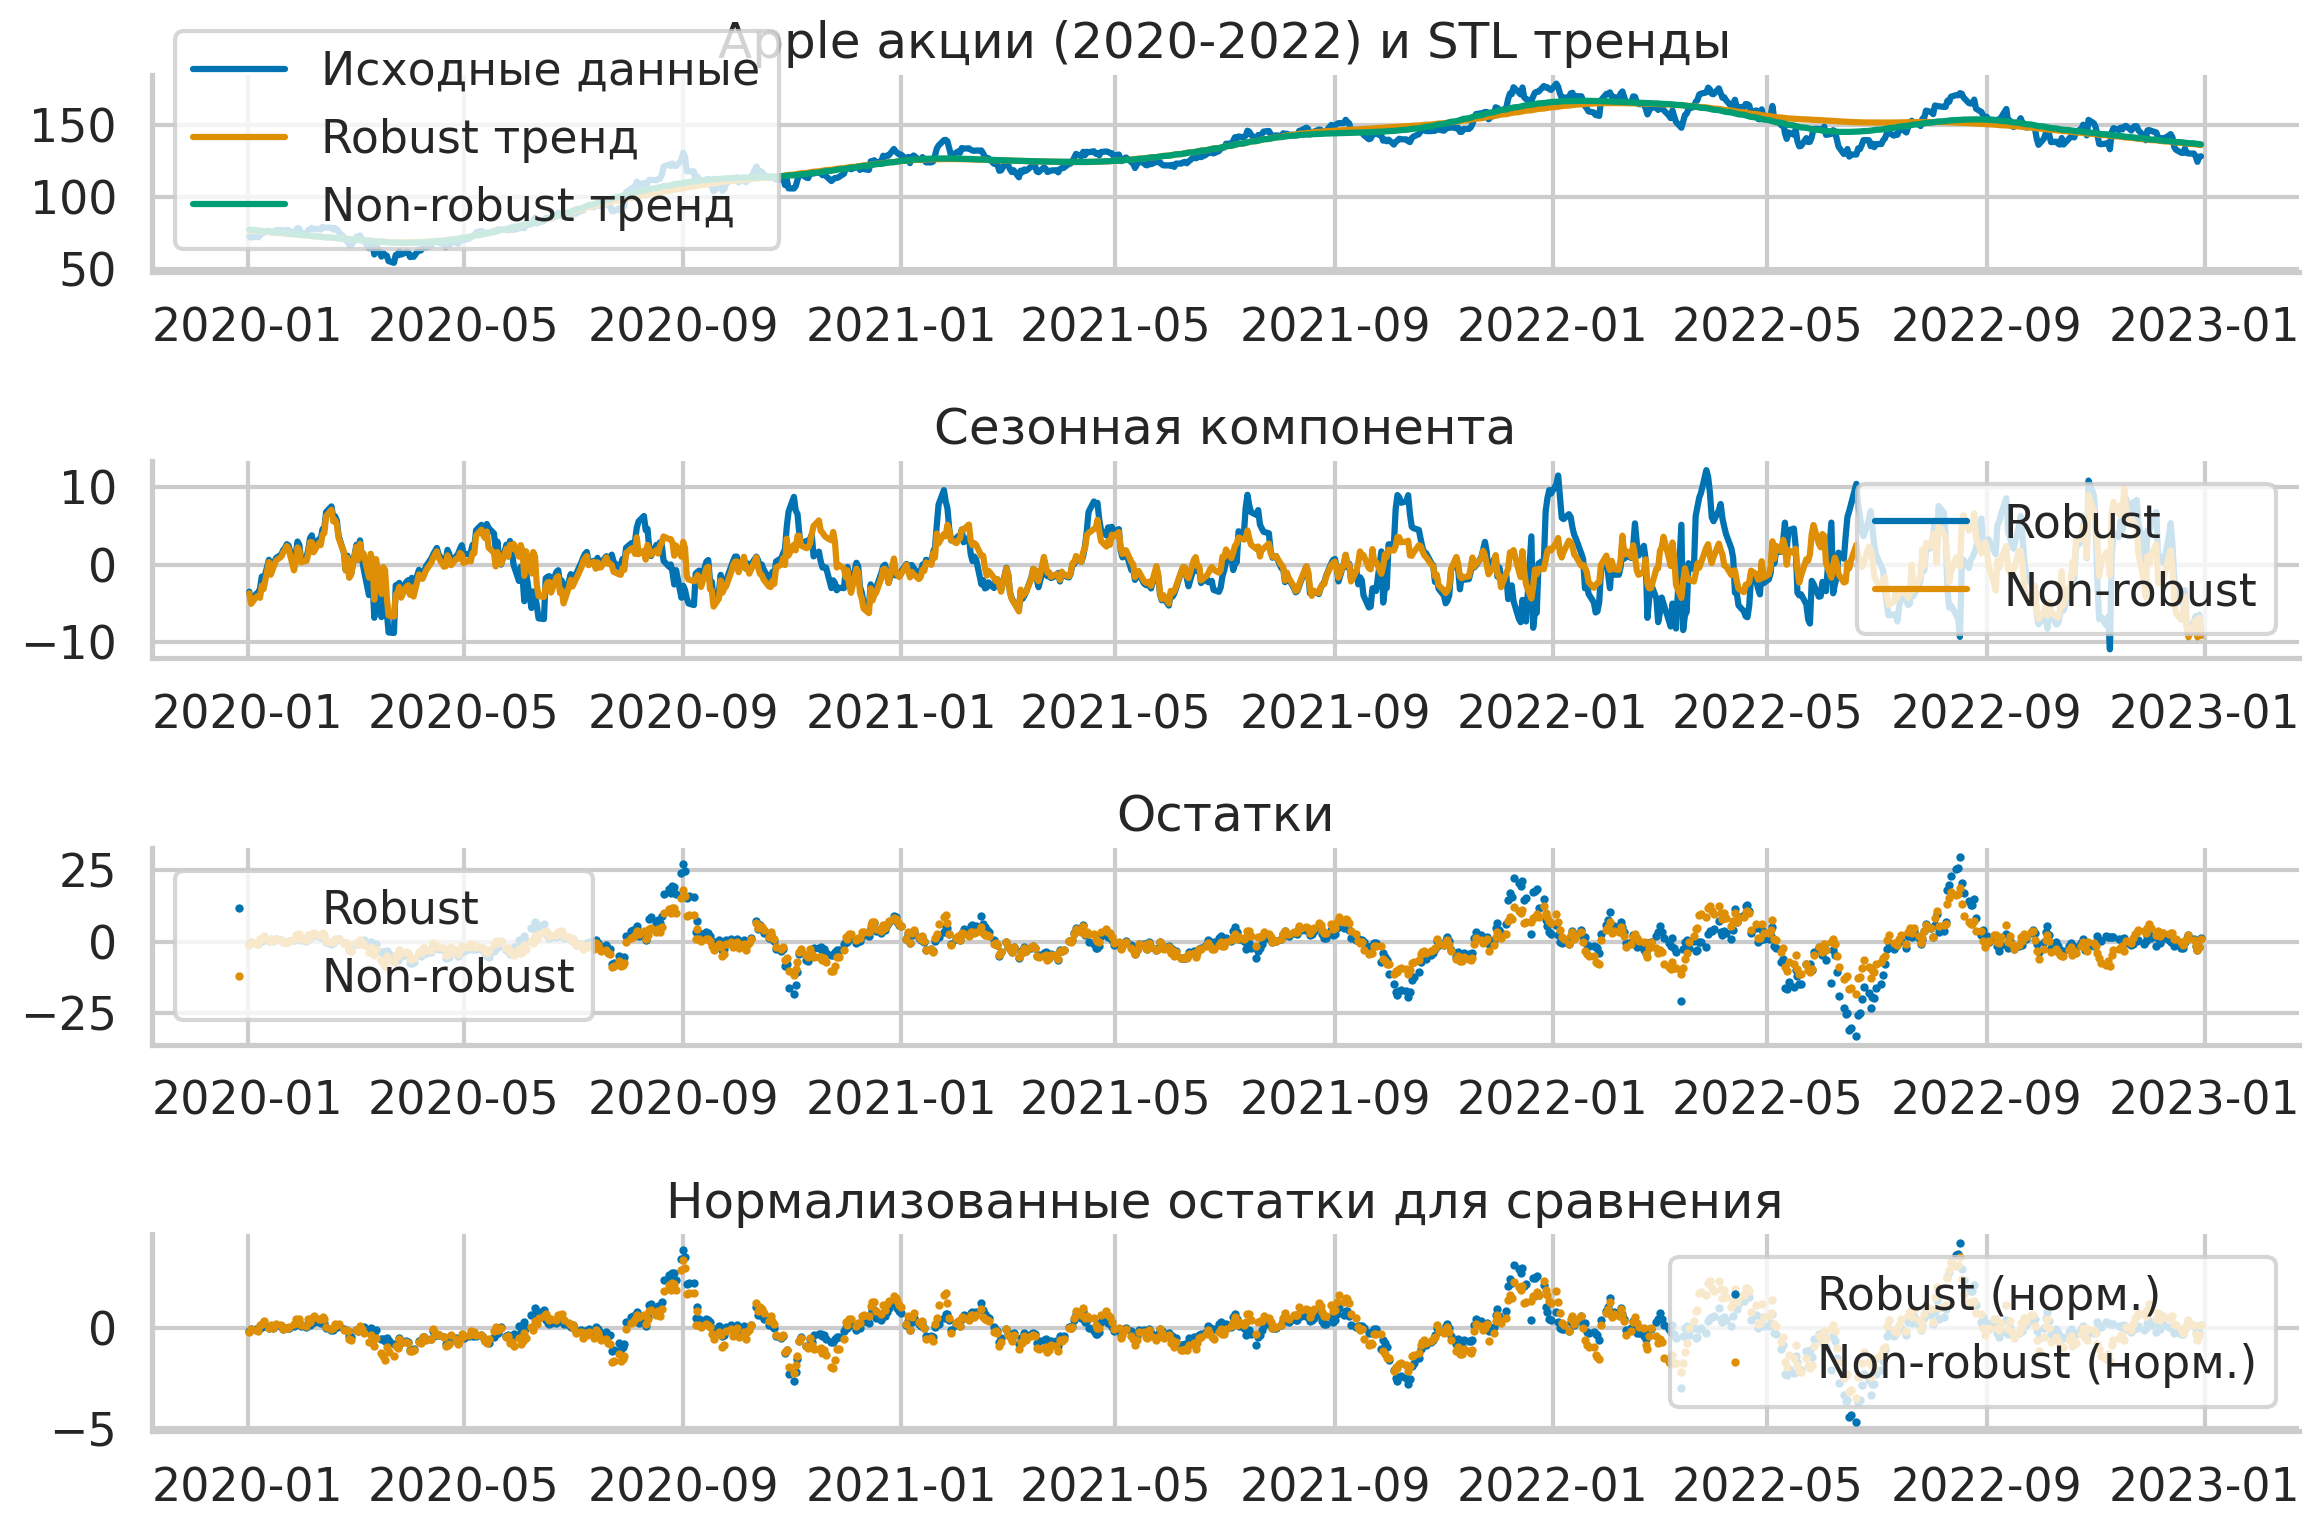

In [27]:
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import STL

# Загрузка данных
df = yf.download("AAPL", start="2020-01-01", end="2022-12-31", progress=False)['Close']
df = df.asfreq('B').ffill()  # Убедимся в ежедневной частоте и заполним пропуски

# Функция для добавления второго набора компонентов на график
def add_stl_to_plot(fig, stl_result, label):
    axs = fig.get_axes()
    for ax, comp in zip(axs[1:], ['trend', 'seasonal', 'resid']):
        series = getattr(stl_result, comp)
        if comp == 'resid':
            ax.plot(series, 'o', markersize=2, label=label)
        else:
            ax.plot(series, label=label)
        if comp == 'trend':
            ax.legend()

# Выполнение декомпозиции
period = 5*4*3  # Пример: 3 месяца (примерная сезонность)
stl_robust = STL(df, period=period, robust=True).fit()
stl_non_robust = STL(df, period=period, robust=False).fit()

# Построение графиков
plt.figure(figsize=(12, 8))

# 1. Исходные данные и тренд
plt.subplot(4, 1, 1)
plt.plot(df, label='Исходные данные')
plt.plot(stl_robust.trend, label='Robust тренд')
plt.plot(stl_non_robust.trend, label='Non-robust тренд')
plt.title('Apple акции (2020-2022) и STL тренды')
plt.legend()

# 2. Сезонная компонента
plt.subplot(4, 1, 2)
plt.plot(stl_robust.seasonal, label='Robust')
plt.plot(stl_non_robust.seasonal, label='Non-robust')
plt.title('Сезонная компонента')
plt.legend()

# 3. Остатки
plt.subplot(4, 1, 3)
plt.plot(stl_robust.resid, 'o', markersize=2, label='Robust')
plt.plot(stl_non_robust.resid, 'o', markersize=2, label='Non-robust')
plt.title('Остатки')
plt.legend()

# 4. Детализированные остатки (масштабированные)
plt.subplot(4, 1, 4)
plt.plot(stl_robust.resid/stl_robust.resid.std(), 'o', markersize=2, label='Robust (норм.)')
plt.plot(stl_non_robust.resid/stl_non_robust.resid.std(), 'o', markersize=2, label='Non-robust (норм.)')
plt.title('Нормализованные остатки для сравнения')
plt.legend()

plt.tight_layout()
sns.despine()
plt.show()

Apply the Hodrick-Prescott filter to the unemployment time series:

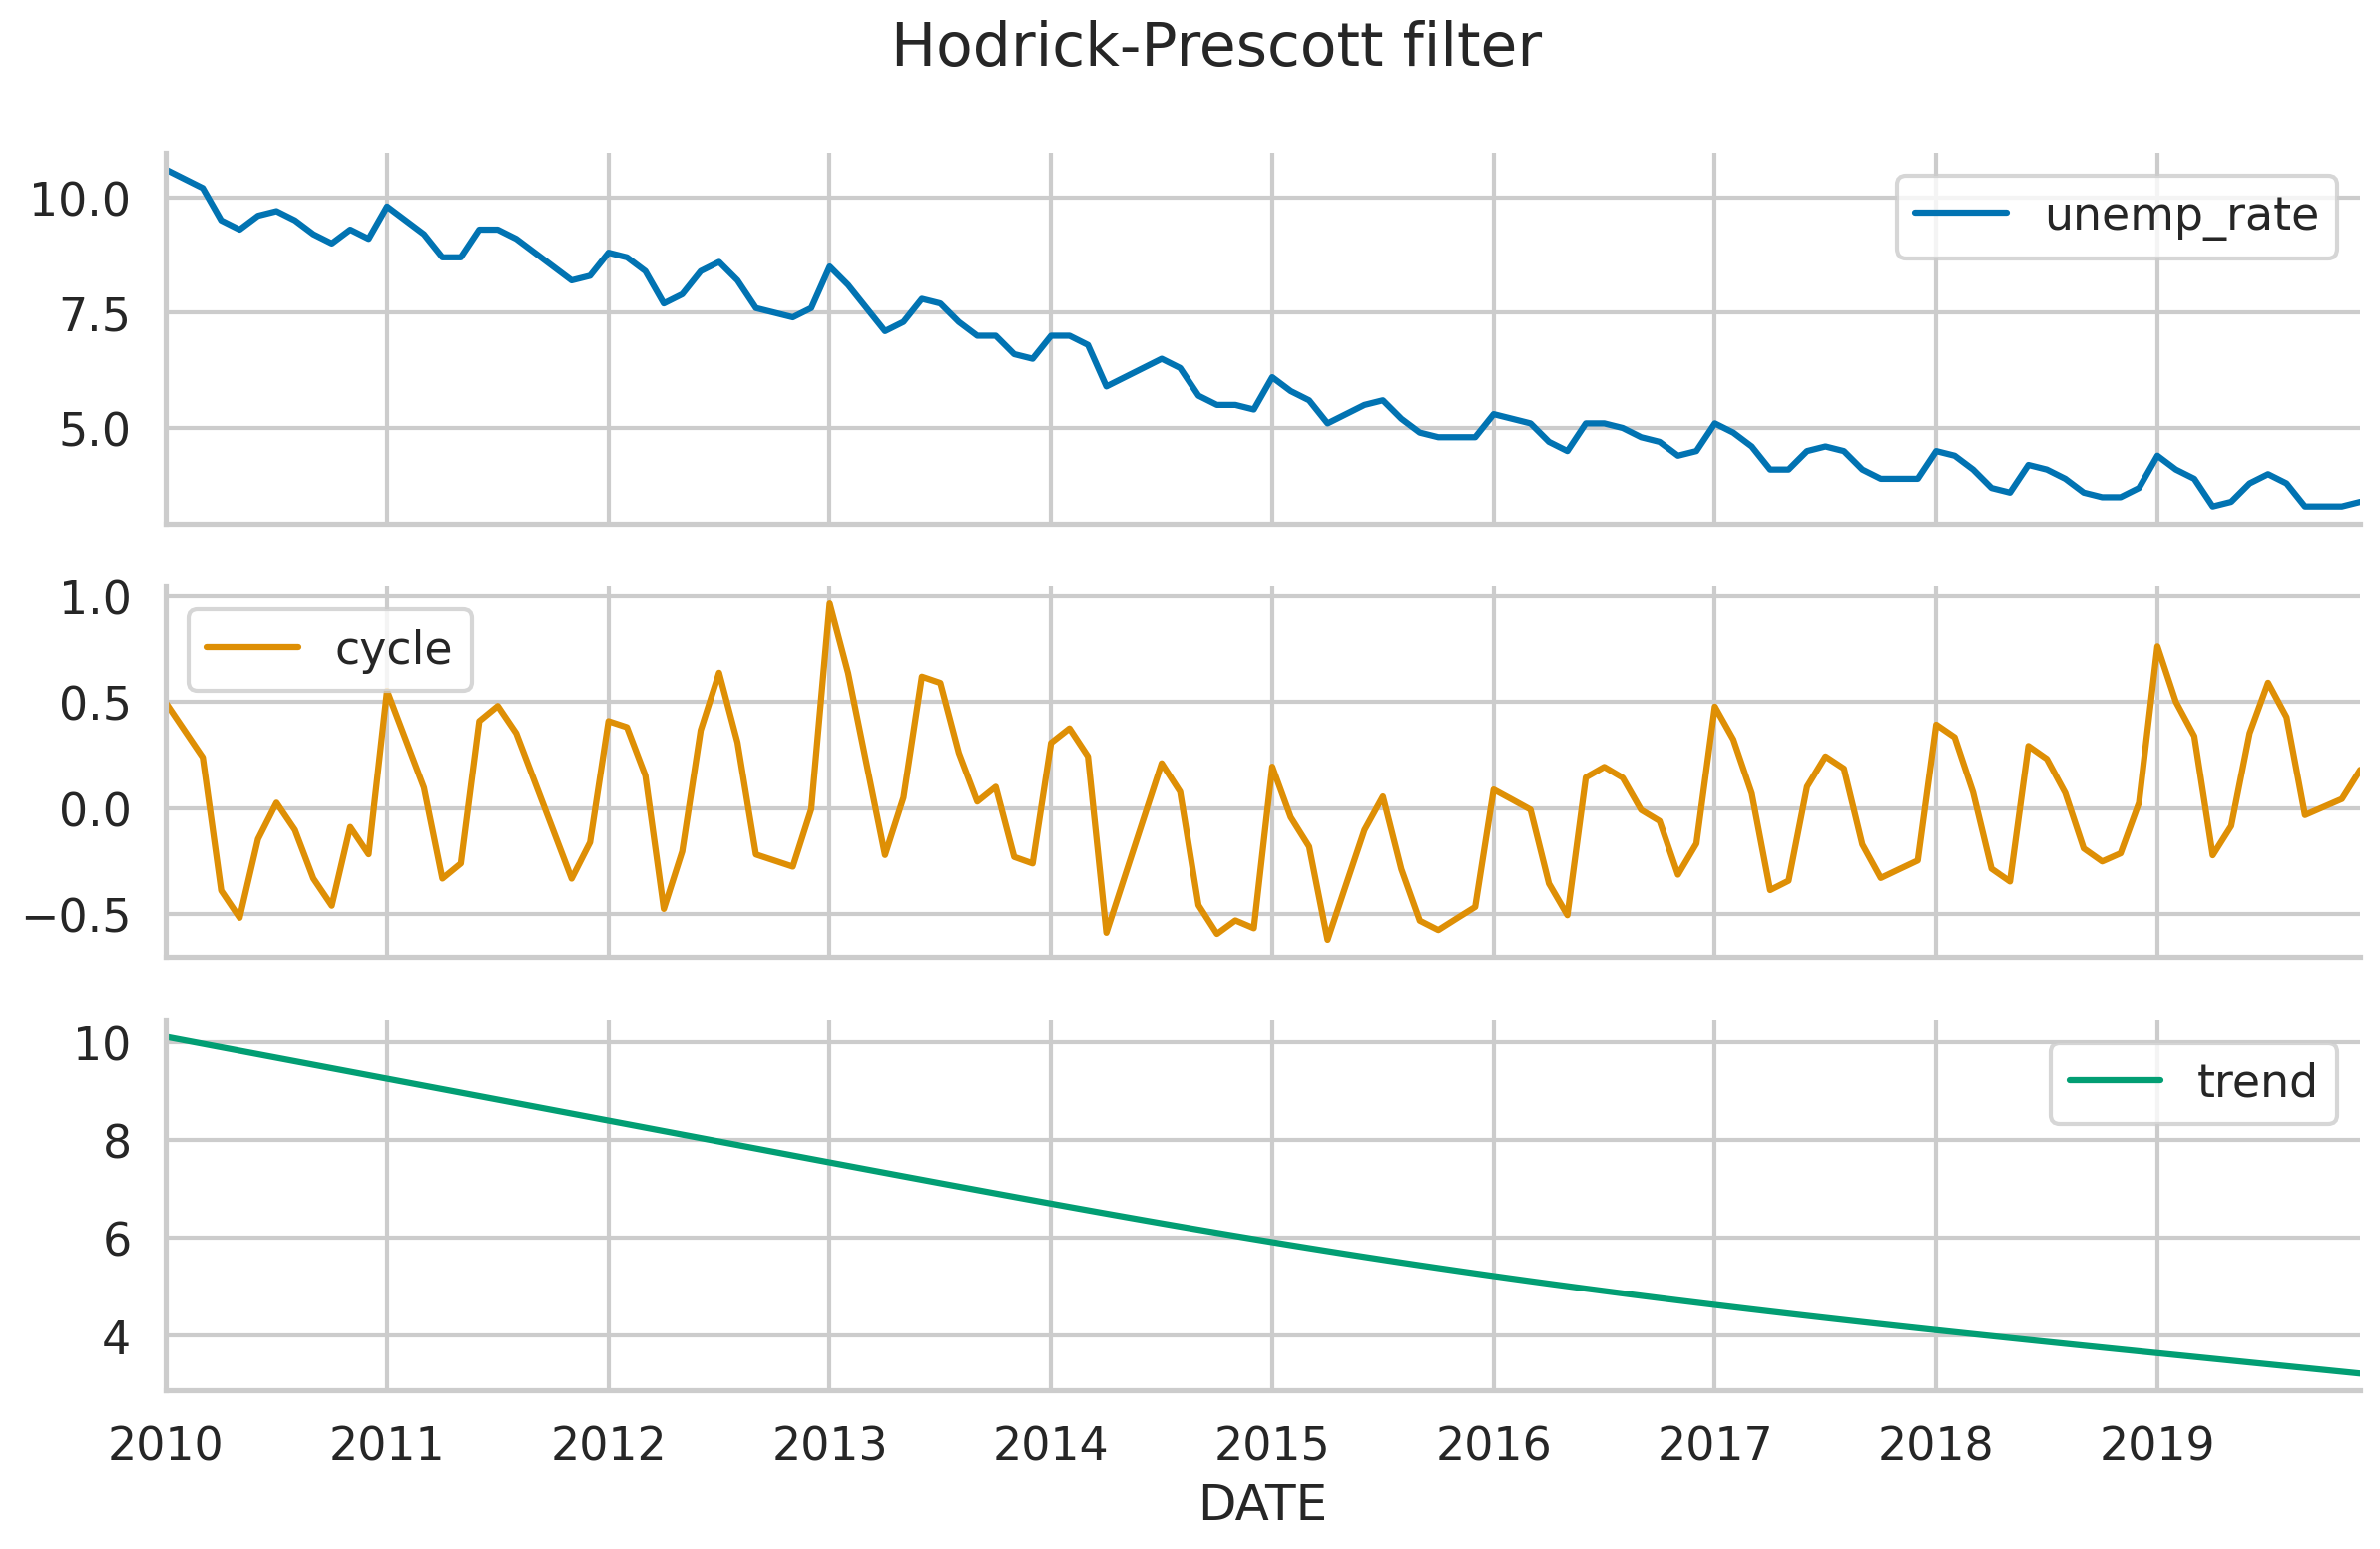

In [30]:
from statsmodels.tsa.filters.hp_filter import hpfilter
df = pdr.get_data_fred('UNRATENSA', start=datetime(2010, 1, 1), end=datetime(2019, 12, 31))
df = df.rename(columns={'UNRATENSA': 'unemp_rate'})
hp_df = df[["unemp_rate"]].copy()
hp_df["cycle"], hp_df["trend"] = hpfilter(hp_df["unemp_rate"], 129600)
hp_df.plot(subplots=True, title="Hodrick-Prescott filter")

sns.despine()
plt.tight_layout()

##Задание 3.
Выполнить моделирование данных по стоимости акций компаний Apple воспользовавшись данными Yahoo: `df = yf.download("AAPL", start="2020-01-01", end="2022-12-31",progress=False)`. Используйте фильтр Hodrick-Prescott. Сравните графически результаты модели с моделями задания 1.

<Figure size 1400x1000 with 0 Axes>

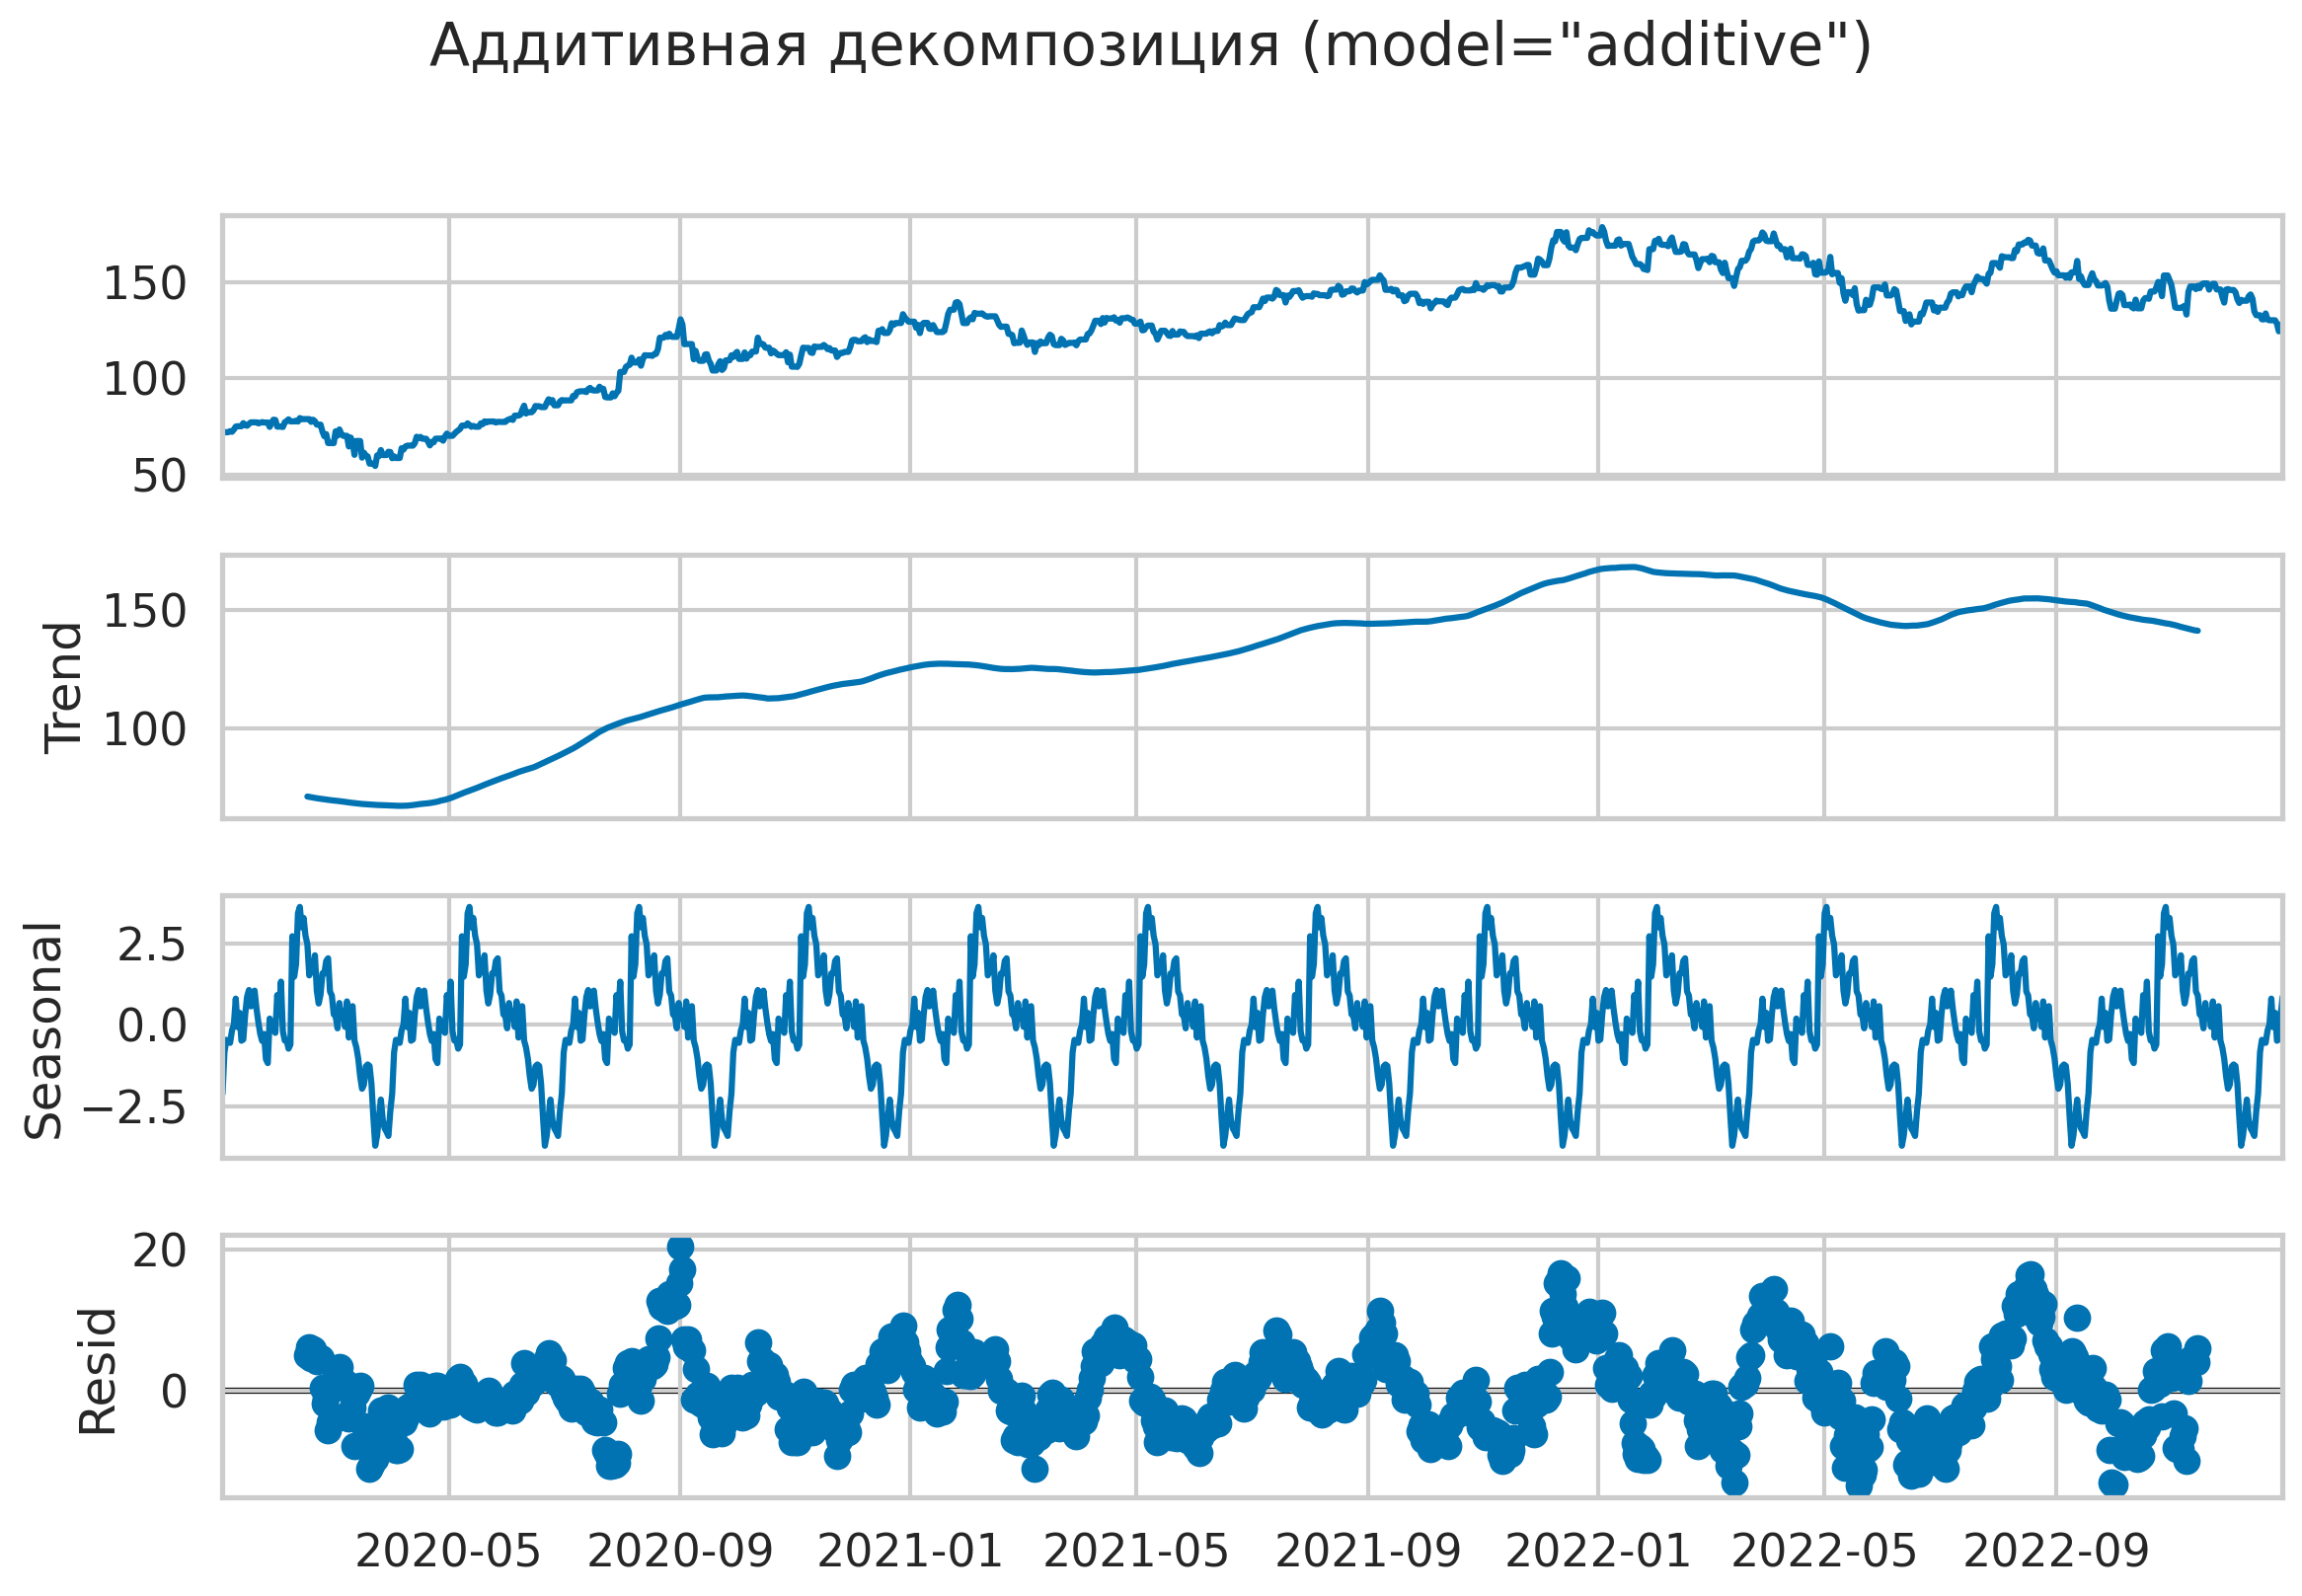

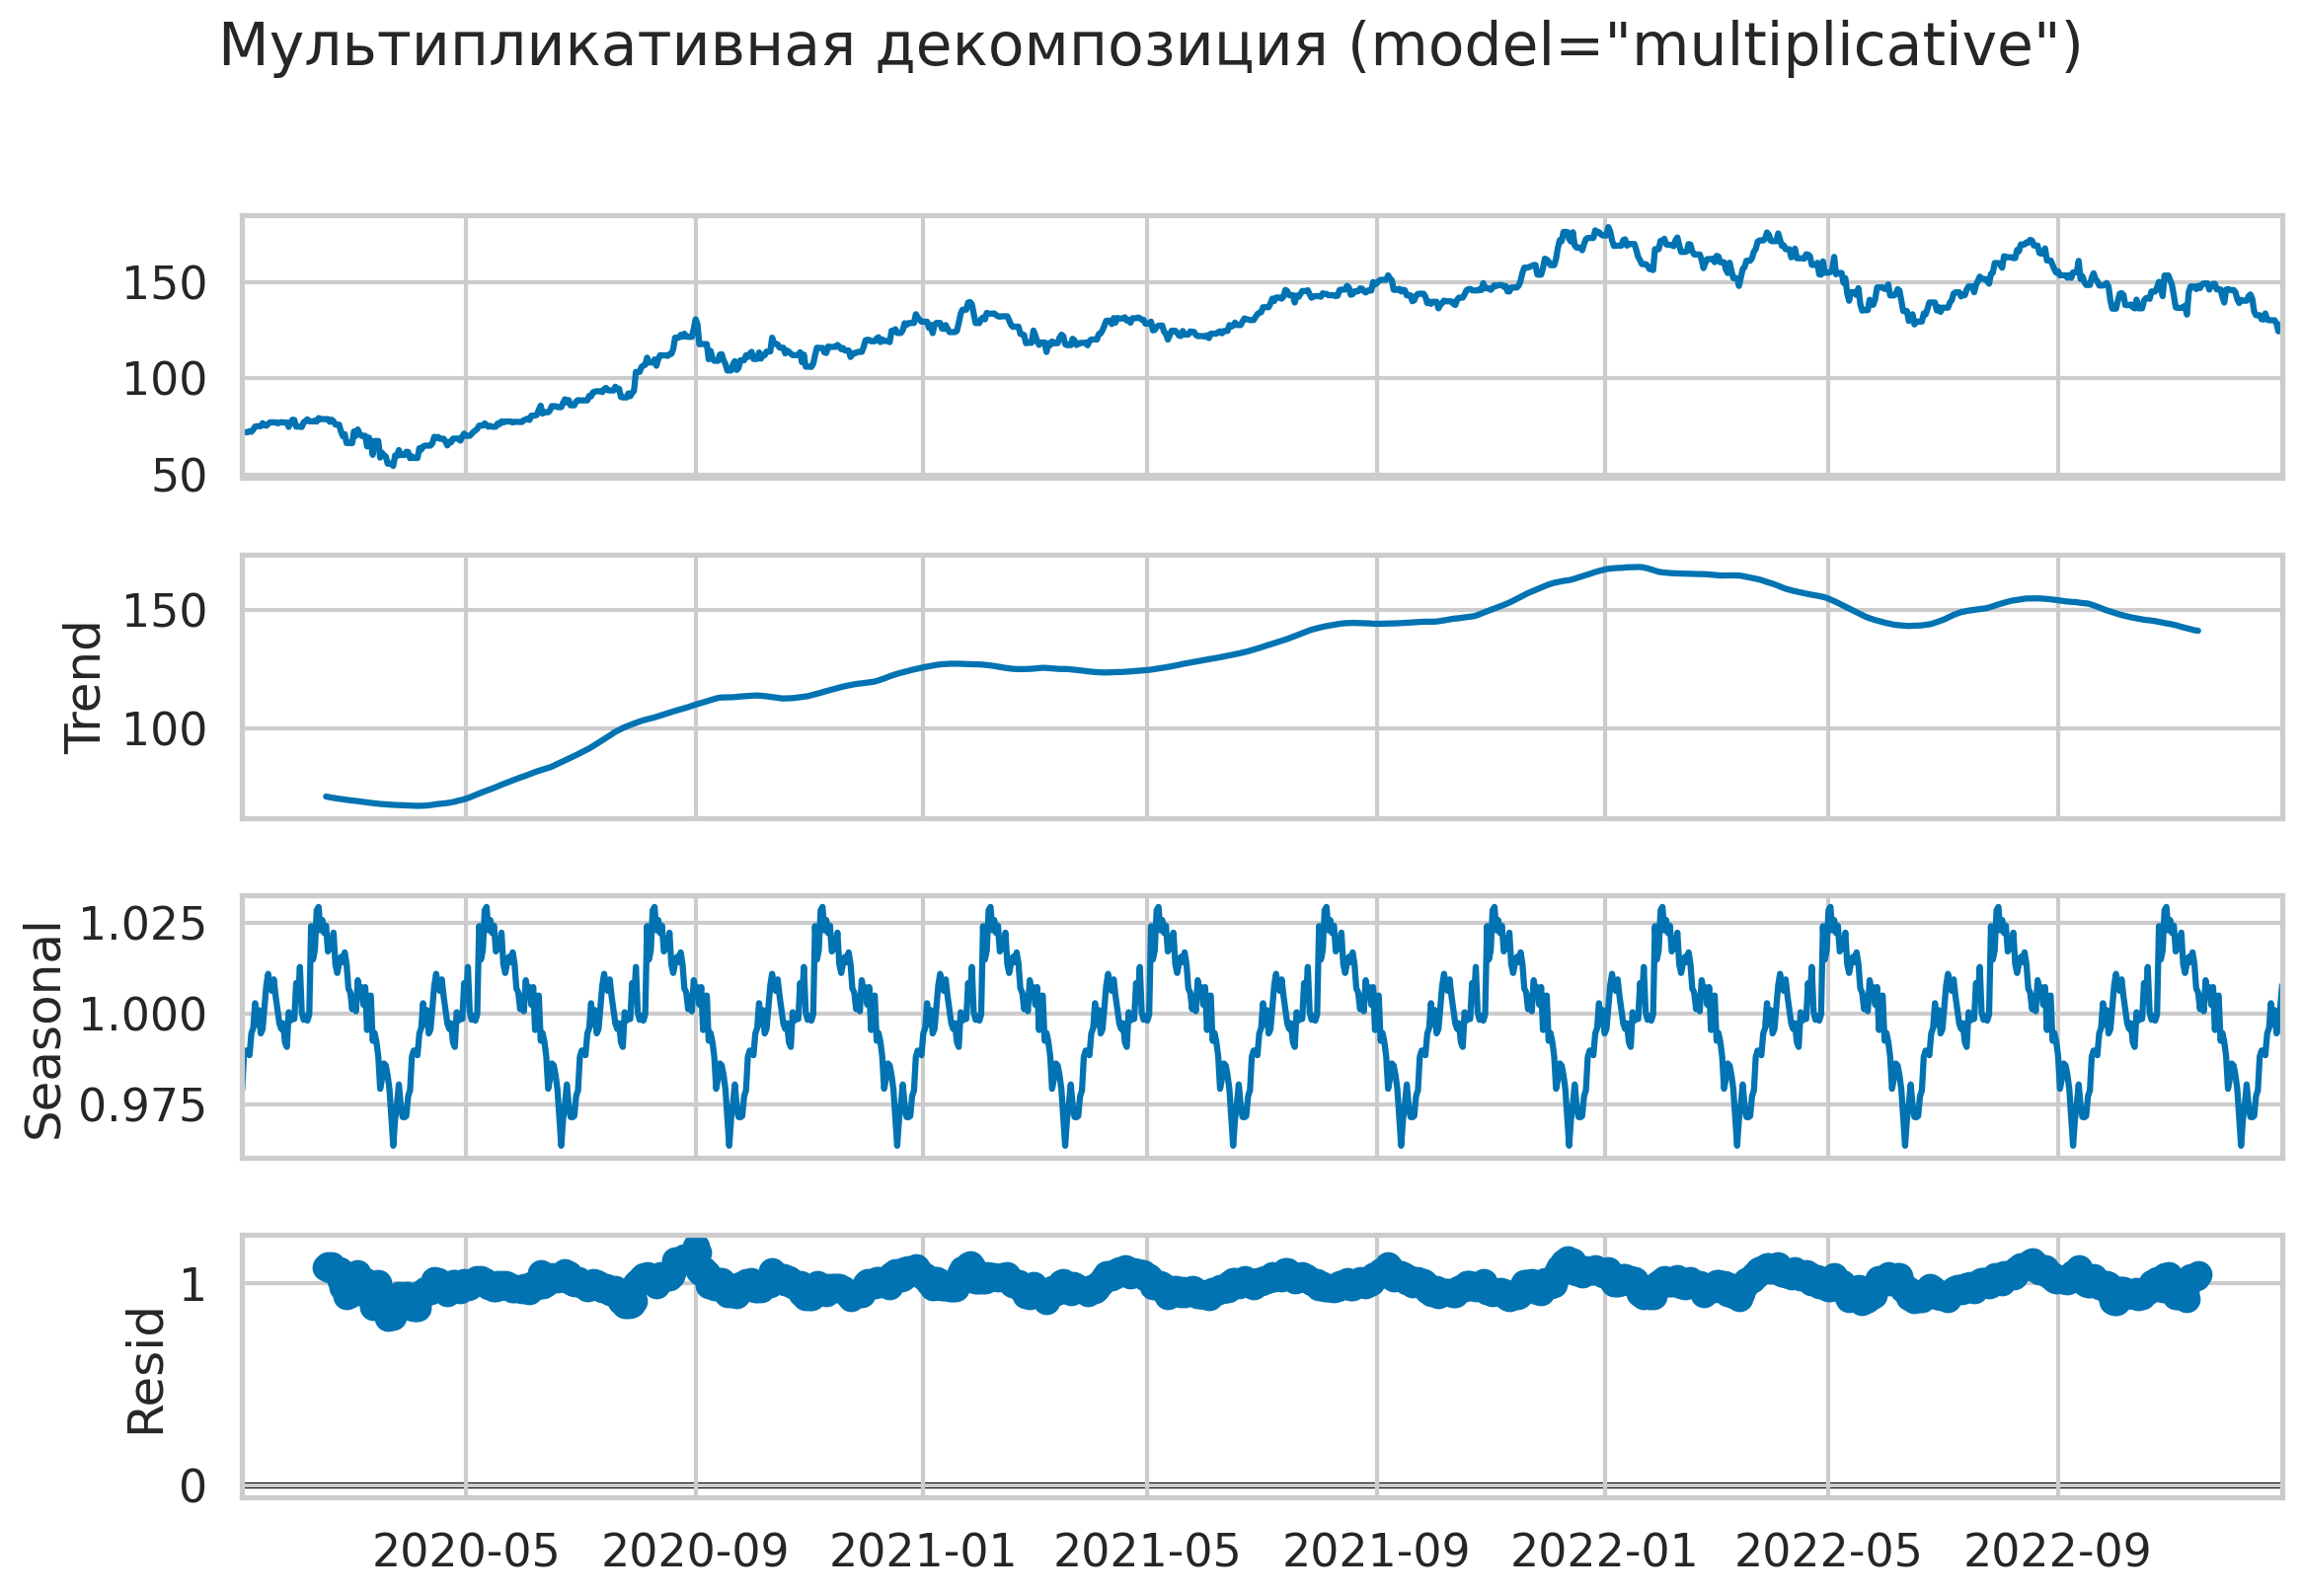

In [38]:
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns

# Загрузка данных
df = yf.download("AAPL", start="2020-01-01", end="2022-12-31", progress=False)['Close']

# Приведение к ежедневной частоте и заполнение пропусков (если есть)
df = df.asfreq('D').ffill()

# 1. Аддитивная модель
result_add = seasonal_decompose(df, model='additive', period=90)  # период ~3 месяца

# 2. Мультипликативная модель
result_mul = seasonal_decompose(df, model='multiplicative', period=90)

# Настройка стиля графиков
sns.set_style("whitegrid")
plt.figure(figsize=(14, 10))

# График для аддитивной модели
result_add.plot()
plt.suptitle('Аддитивная декомпозиция (model="additive")', y=1.02)
plt.tight_layout()

# График для мультипликативной модели
result_mul.plot()
plt.suptitle('Мультипликативная декомпозиция (model="multiplicative")', y=1.02)
plt.tight_layout()

plt.show()

## 6.2 Testing for stationarity in time series

### Getting ready

1. Import the libraries and authenticate:

In [31]:
import pandas as pd
import nasdaqdatalink

nasdaqdatalink.ApiConfig.api_key = "YOUR_KEY_HERE"

2. Download the monthly US unemployment rate from years 2010-2019:

In [33]:
df = pdr.get_data_fred('UNRATENSA', start=datetime(2010, 1, 1), end=datetime(2019, 12, 31))
df = df.rename(columns={'UNRATENSA': 'unemp_rate'})
df.head()

unemp_rate
DATE                  
2010-01-01        10.6
2010-02-01        10.4
2010-03-01        10.2
2010-04-01         9.5
2010-05-01         9.3

### How to do it...

1. Import the libraries:

In [34]:
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss

2. Define a function for running the ADF test:

In [35]:
def adf_test(x):
    """
    Function for performing the Augmented Dickey-Fuller test for stationarity

    Null Hypothesis: time series is not stationary
    Alternate Hypothesis: time series is stationary

    Parameters
    ----------
    x : pd.Series / np.array
        The time series to be checked for stationarity

    Returns
    -------
    results: pd.DataFrame
        A DataFrame with the ADF test's results
    """

    indices = ["Test Statistic", "p-value",
               "# of Lags Used", "# of Observations Used"]

    adf_test = adfuller(x, autolag="AIC")
    results = pd.Series(adf_test[0:4], index=indices)

    for key, value in adf_test[4].items():
        results[f"Critical Value ({key})"] = value

    return results


In [36]:
adf_test(df["unemp_rate"])

Test Statistic             -2.053411
p-value                     0.263656
# of Lags Used             12.000000
# of Observations Used    107.000000
Critical Value (1%)        -3.492996
Critical Value (5%)        -2.888955
Critical Value (10%)       -2.581393
dtype: float64

3. Define a function for running the KPSS test:

In [39]:
def kpss_test(x, h0_type="c"):
    """
    Function for performing the Kwiatkowski-Phillips-Schmidt-Shin test for stationarity

    Null Hypothesis: time series is stationary
    Alternate Hypothesis: time series is not stationary

    Parameters
    ----------
    x: pd.Series / np.array
        The time series to be checked for stationarity
    h0_type: str{"c", "ct"}
        Indicates the null hypothesis of the KPSS test:
            * "c": The data is stationary around a constant(default)
            * "ct": The data is stationary around a trend

    Returns
    -------
    results: pd.DataFrame
        A DataFrame with the KPSS test's results
    """

    indices = ["Test Statistic", "p-value", "# of Lags"]

    kpss_test = kpss(x, regression=h0_type)
    results = pd.Series(kpss_test[0:3], index=indices)

    for key, value in kpss_test[3].items():
        results[f"Critical Value ({key})"] = value

    return results

In [41]:
# Download data from FRED
df = pdr.get_data_fred('UNRATENSA', start=datetime(2010, 1, 1), end=datetime(2019, 12, 31))
df = df.rename(columns={'UNRATENSA': 'unemp_rate'})
df.head()

unemp_rate
DATE                  
2010-01-01        10.6
2010-02-01        10.4
2010-03-01        10.2
2010-04-01         9.5
2010-05-01         9.3

In [42]:
kpss_test(df["unemp_rate"])

<ipython-input-39-8e37a4ea041a>:25: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test = kpss(x, regression=h0_type)


Test Statistic           1.799224
p-value                  0.010000
# of Lags                6.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64

4. Generate the ACF/PACF plots:

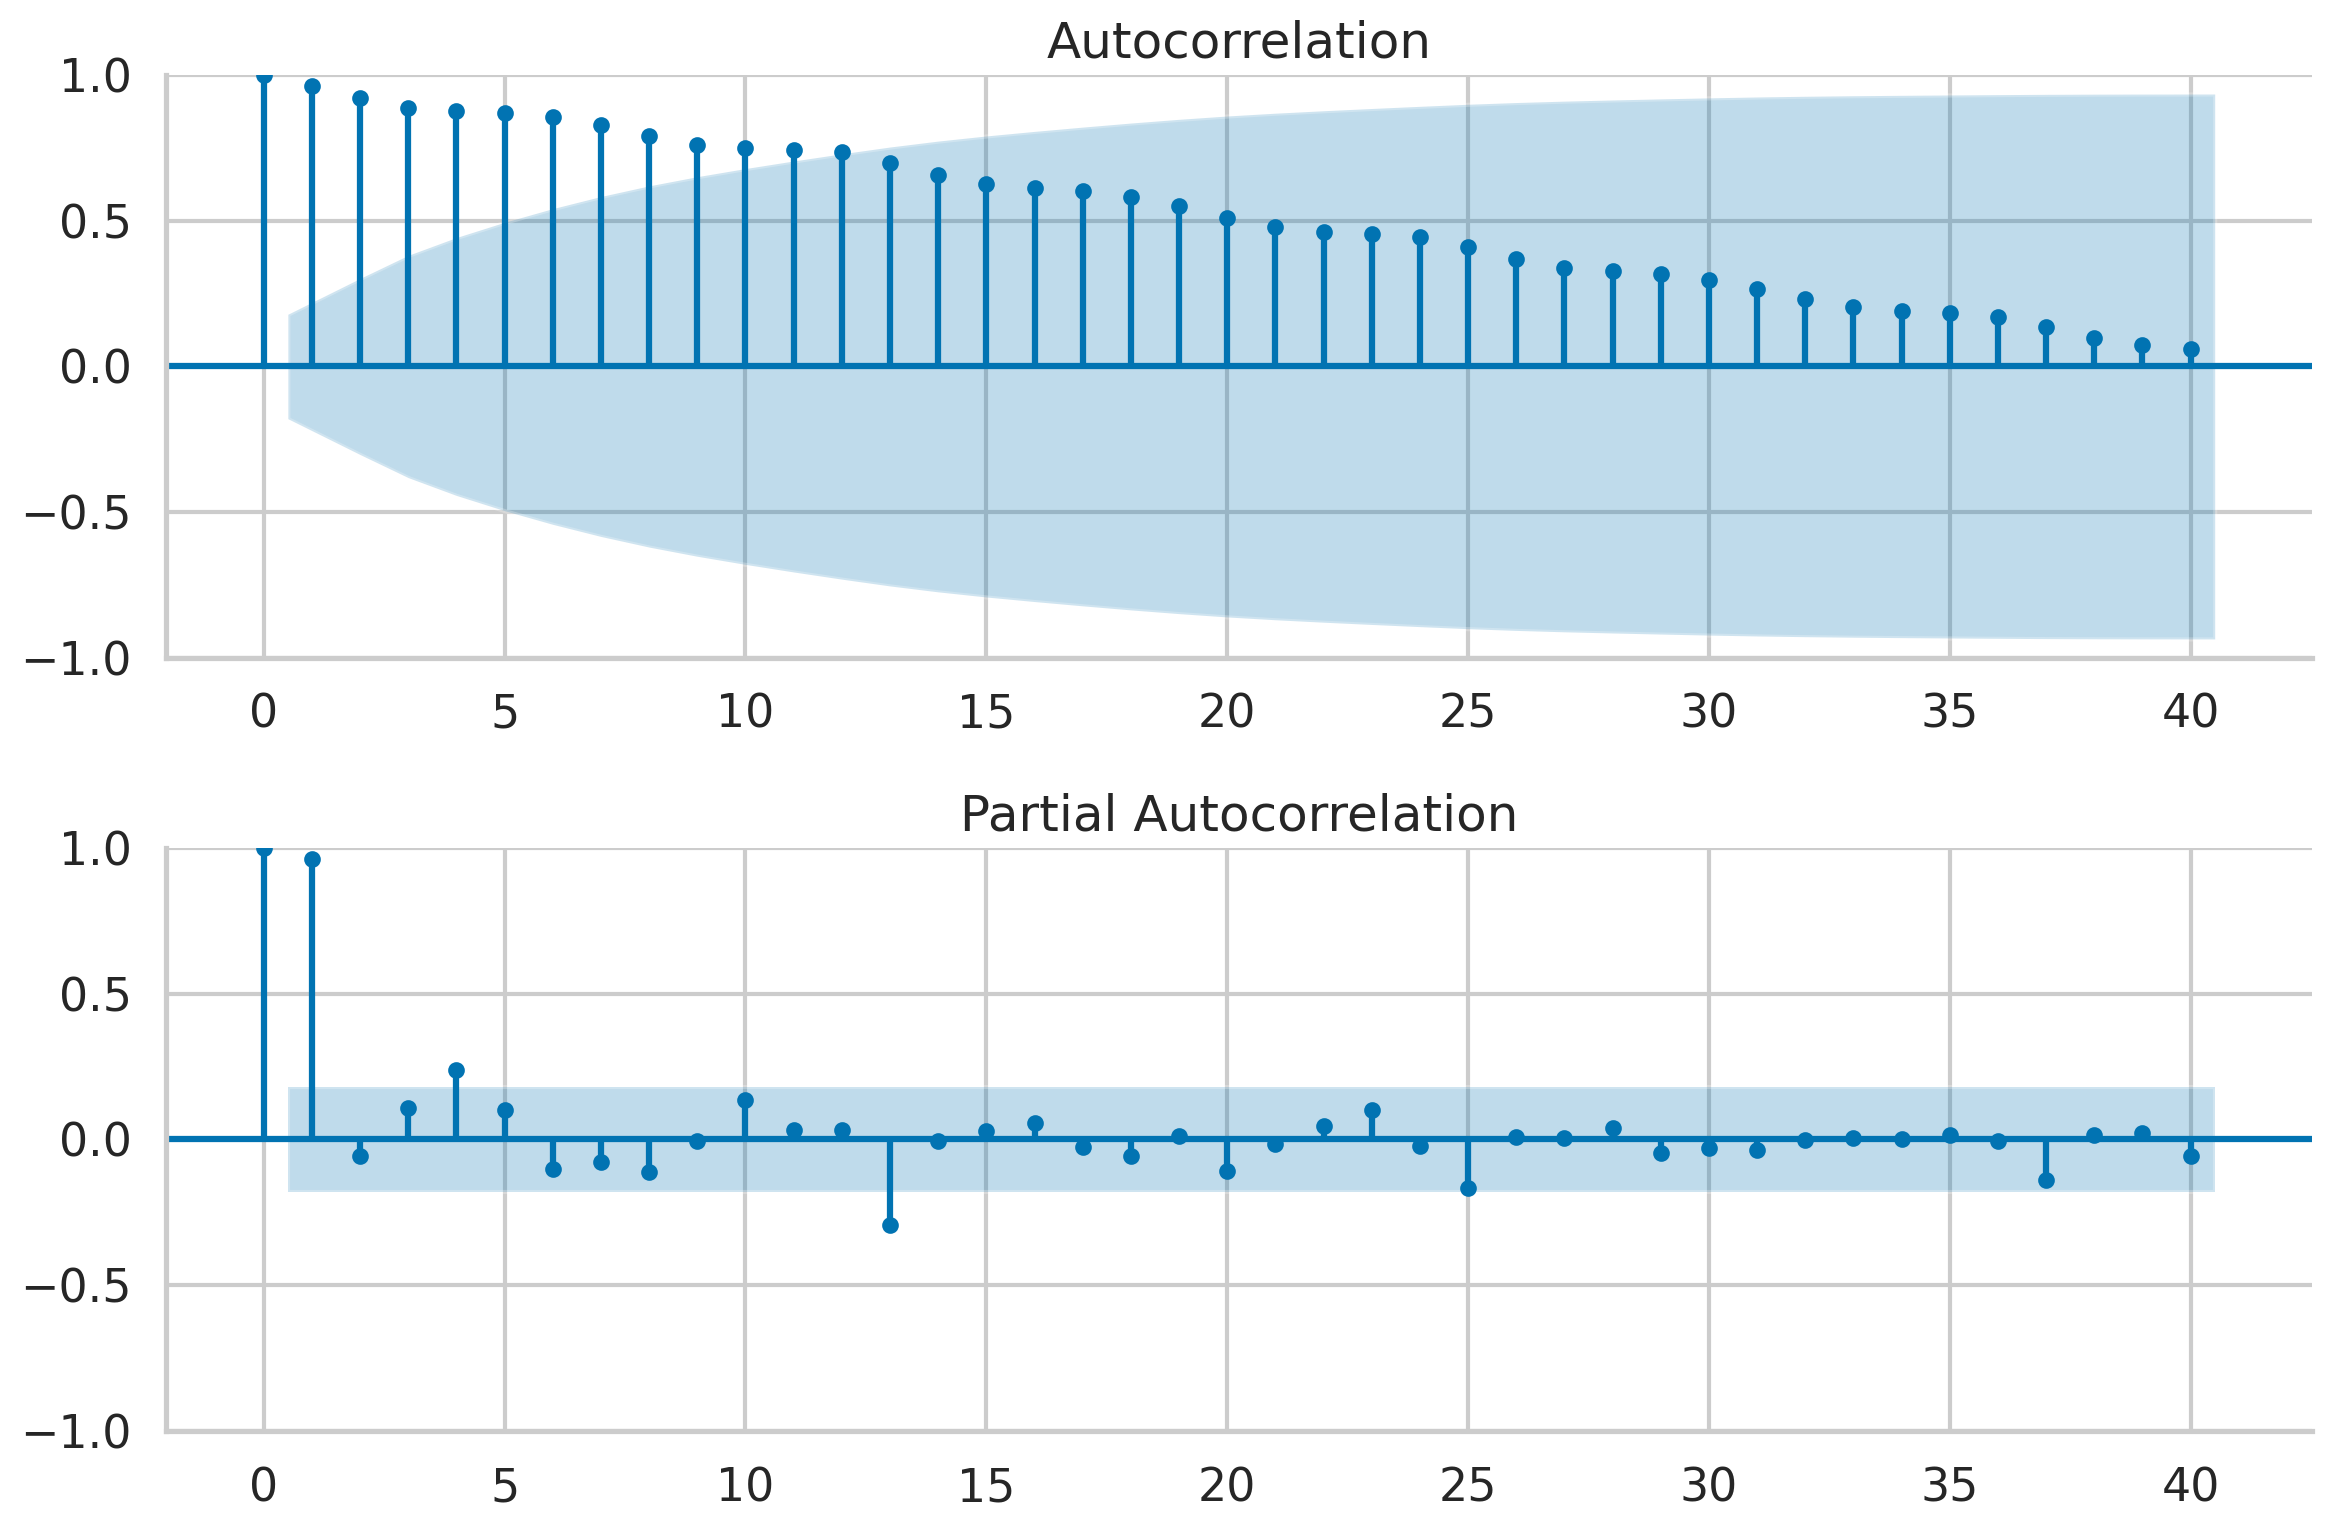

In [43]:
N_LAGS = 40
SIGNIFICANCE_LEVEL = 0.05

fig, ax = plt.subplots(2, 1)
plot_acf(df["unemp_rate"], ax=ax[0], lags=N_LAGS,
         alpha=SIGNIFICANCE_LEVEL)
plot_pacf(df["unemp_rate"], ax=ax[1], lags=N_LAGS,
          alpha=SIGNIFICANCE_LEVEL)

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_6_7", dpi=200)

### There's more

1. Carry out the ADF test using the `arch` library:

In [52]:
!pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 12.8 MB/s eta 0:00:00


In [53]:
from arch.unitroot import ADF
adf = ADF(df["unemp_rate"])
print(adf.summary().as_text())

   Augmented Dickey-Fuller Results   
Test Statistic                 -2.053
P-value                         0.264
Lags                               12
-------------------------------------

Trend: Constant
Critical Values: -3.49 (1%), -2.89 (5%), -2.58 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


2. Carry out the Zivot-Andrews test using the `arch` library:

In [54]:
from arch.unitroot import ZivotAndrews
za = ZivotAndrews(df["unemp_rate"])
print(za.summary().as_text())

        Zivot-Andrews Results        
Test Statistic                 -2.551
P-value                         0.982
Lags                               12
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary.


## Задание 4.
Проведите тестирование на стационарность данных по стоимости акций компании Apple, извлеченных из Yahoo. См. предыдущие задания.

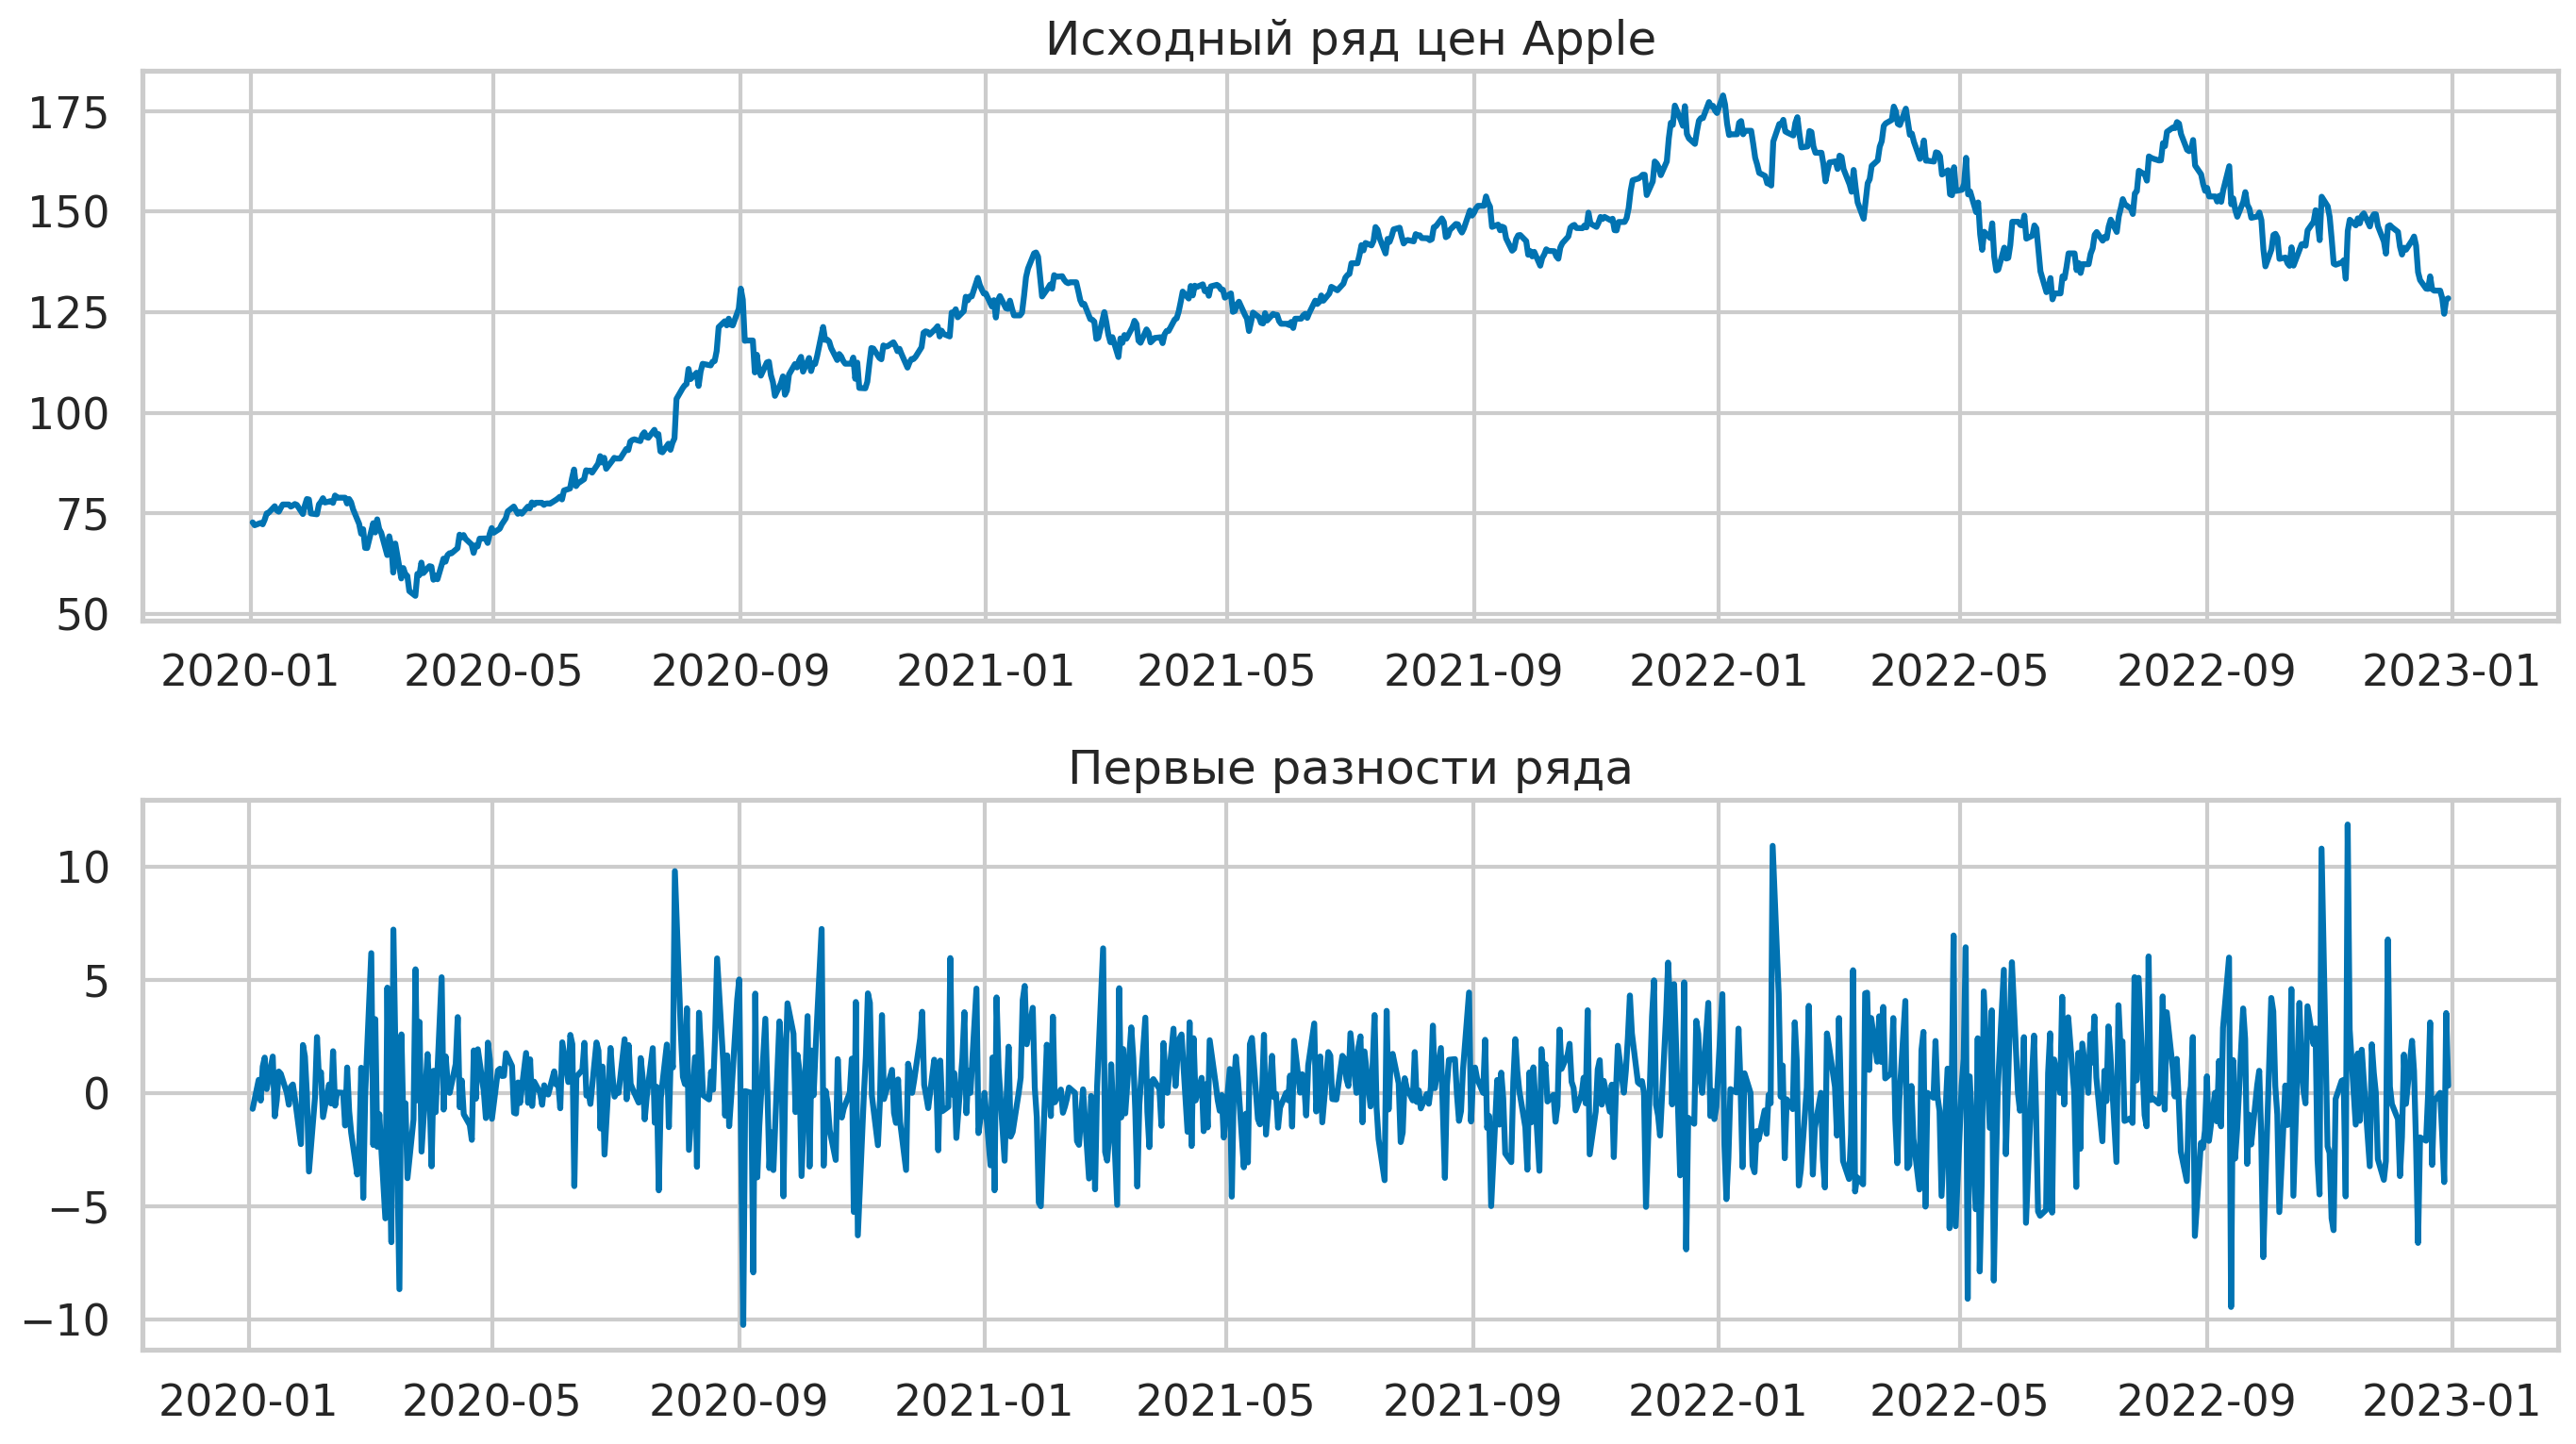

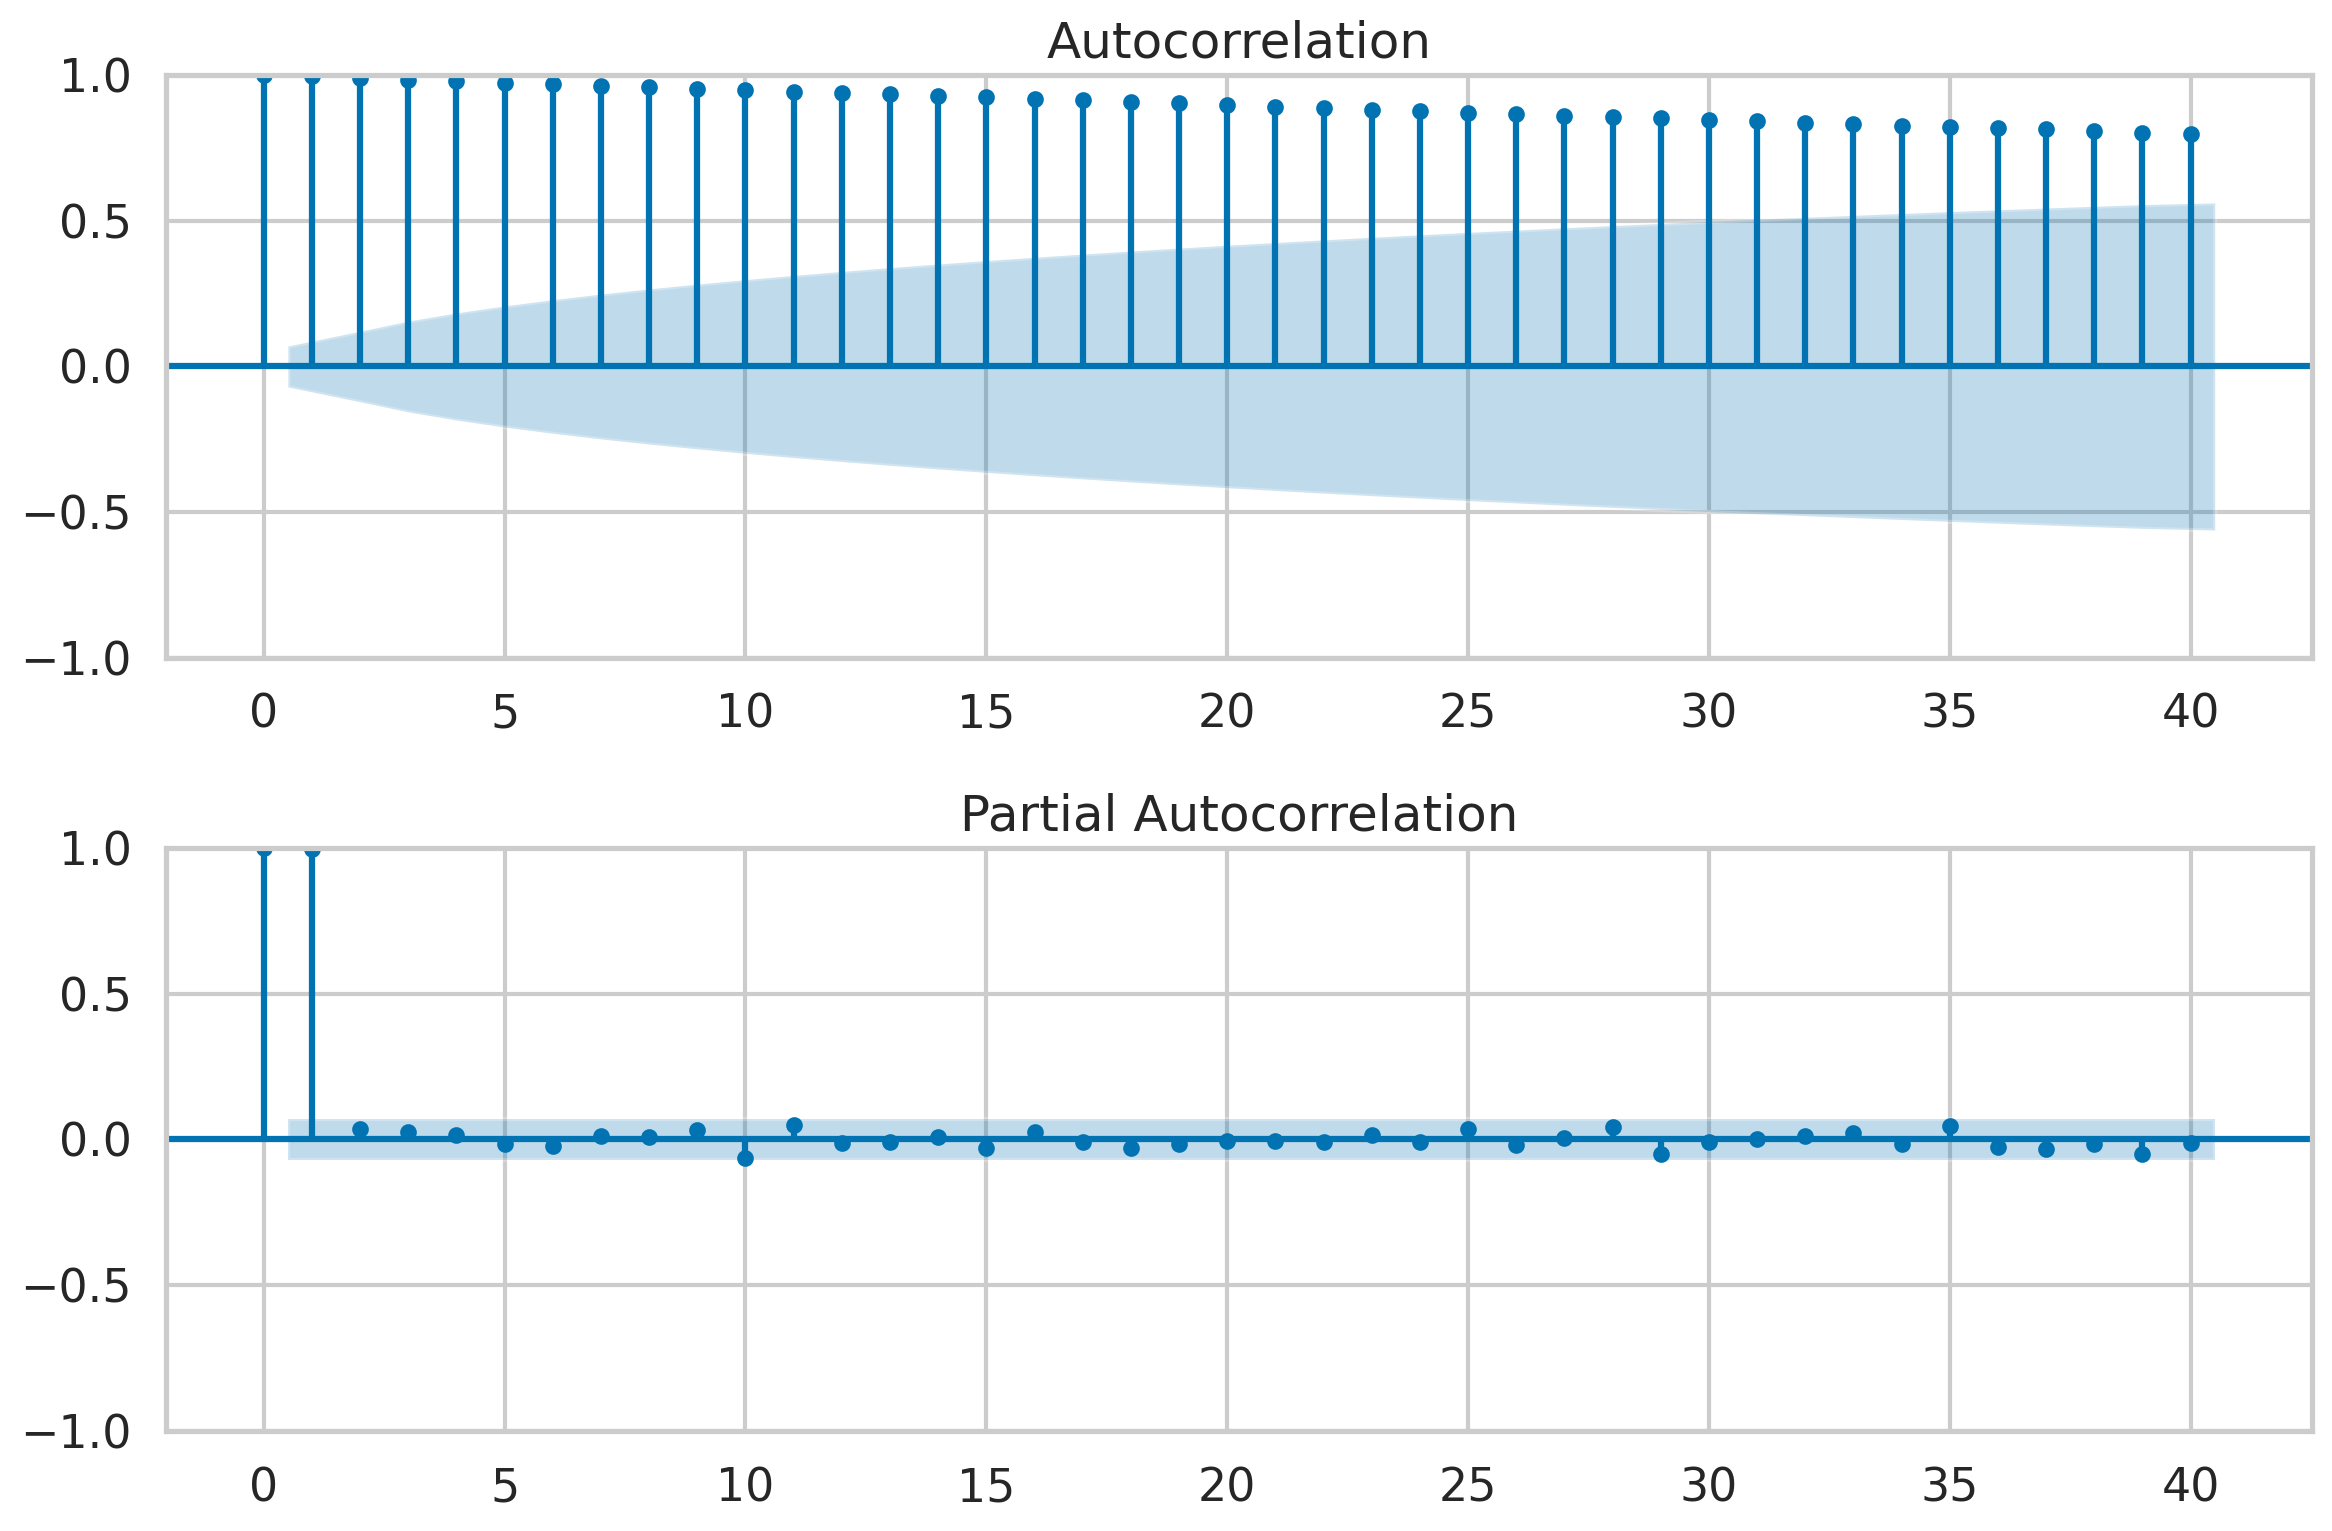

ТЕСТИРОВАНИЕ ИСХОДНОГО РЯДА:
Результаты теста Дики-Фуллера:
ADF Statistic: -1.8887
p-value: 0.3374
Критические значения:
   1%: -3.4388
   5%: -2.8653
   10%: -2.5687

Результаты теста KPSS:
KPSS Statistic: 3.4565
p-value: 0.0100
Критические значения:
   10%: 0.3470
   5%: 0.4630
   2.5%: 0.5740
   1%: 0.7390

ТЕСТИРОВАНИЕ ПЕРВЫХ РАЗНОСТЕЙ:
Результаты теста Дики-Фуллера:
ADF Statistic: -29.8046
p-value: 0.0000
Критические значения:
   1%: -3.4388
   5%: -2.8653
   10%: -2.5687

Результаты теста KPSS:
KPSS Statistic: 0.2319
p-value: 0.1000
Критические значения:
   10%: 0.3470
   5%: 0.4630
   2.5%: 0.5740
   1%: 0.7390


<ipython-input-55-f939ada1e7ed>:43: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpsstest = kpss(timeseries, regression='c', nlags='auto')
<ipython-input-55-f939ada1e7ed>:43: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries, regression='c', nlags='auto')


In [55]:
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import seaborn as sns

# Загрузка данных
df = yf.download("AAPL", start="2020-01-01", end="2022-12-31", progress=False)['Close']
df = df.asfreq('B').ffill()  # Бизнес-дни, заполнение пропусков

# 1. Визуальный анализ
plt.figure(figsize=(14, 8))
plt.subplot(2,1,1)
plt.plot(df)
plt.title('Исходный ряд цен Apple')
plt.subplot(2,1,2)
plt.plot(df.diff().dropna())  # Первые разности
plt.title('Первые разности ряда')
plt.tight_layout()
plt.show()

# 2. Графики ACF/PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(df, lags=40, ax=ax1)
plot_pacf(df, lags=40, ax=ax2)
plt.tight_layout()
plt.show()

# 3. Статистические тесты
def test_stationarity(timeseries):
    """Функция для проведения тестов на стационарность"""
    # Тест Дики-Фуллера (ADF)
    print('Результаты теста Дики-Фуллера:')
    dftest = adfuller(timeseries, autolag='AIC')
    print(f'ADF Statistic: {dftest[0]:.4f}')
    print(f'p-value: {dftest[1]:.4f}')
    print(f'Критические значения:')
    for key, val in dftest[4].items():
        print(f'   {key}: {val:.4f}')

    # Тест KPSS
    print('\nРезультаты теста KPSS:')
    kpsstest = kpss(timeseries, regression='c', nlags='auto')
    print(f'KPSS Statistic: {kpsstest[0]:.4f}')
    print(f'p-value: {kpsstest[1]:.4f}')
    print(f'Критические значения:')
    for key, val in kpsstest[3].items():
        print(f'   {key}: {val:.4f}')

# Тестируем исходный ряд и первые разности
print("="*50)
print("ТЕСТИРОВАНИЕ ИСХОДНОГО РЯДА:")
test_stationarity(df)

print("\n" + "="*50)
print("ТЕСТИРОВАНИЕ ПЕРВЫХ РАЗНОСТЕЙ:")
test_stationarity(df.diff().dropna())

## 6.3 Correcting for stationarity in time series

### How to do it...

1. Import the libraries, authenticate and update the inflation data:

In [57]:
!pip install cpi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.5/18.5 MB 46.9 MB/s eta 0:00:00


In [60]:
!pip install test_autocorrelation

ERROR: Could not find a version that satisfies the requirement test_autocorrelation (from versions: none)
ERROR: No matching distribution found for test_autocorrelation


In [ ]:
import pandas as pd
import numpy as np
import nasdaqdatalink
import cpi
from datetime import date
from chapter_6_utils import test_autocorrelation

nasdaqdatalink.ApiConfig.api_key = "YOUR_KEY_HERE"

# update the CPI data (if needed)
# cpi.update()

2. Download the prices of gold for 2000-2010 and resample to monthly values:

In [ ]:
df = (
    nasdaqdatalink.get(dataset="WGC/GOLD_MONAVG_USD",
                       start_date="2000-01-01",
                       end_date="2010-12-31")
    .rename(columns={"Value": "price"})
    .resample("M")
    .last()
)

df.head()

As a confirmation, we can check if the series is stationary -> it is not.

In [ ]:
fig = test_autocorrelation(df["price"])

3. Deflate the gold prices (to 2010-12-31 USD values) and plot the results:

In [ ]:
DEFL_DATE = date(2010, 12, 31)

df["dt_index"] = pd.to_datetime(df.index)
df["price_deflated"] = df.apply(
    lambda x: cpi.inflate(x["price"], x["dt_index"], DEFL_DATE),
    axis=1
)

(
    df.loc[:, ["price", "price_deflated"]]
    .plot(title="Gold Price (deflated)")
)

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_6_8", dpi=200)

4. Apply the natural logarithm to the deflated series and plot it together with the rolling metrics:

In [ ]:
WINDOW = 12
selected_columns = ["price_log", "rolling_mean_log",
                    "rolling_std_log"]

df["price_log"] = np.log(df.price_deflated)
df["rolling_mean_log"] = df.price_log.rolling(WINDOW) \
                           .mean()
df["rolling_std_log"] = df.price_log.rolling(WINDOW) \
                          .std()

(
    df[selected_columns]
    .plot(title="Gold Price (deflated + logged)",
          subplots=True)
)

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_6_9", dpi=200)

5. Use the `test_autocorrelation` (helper function for this chapter) to investigate if the series became stationary:

In [ ]:
fig = test_autocorrelation(df["price_log"])

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_6_10", dpi=200)

6. Apply differencing to the series and plot the results:

In [ ]:
selected_columns = ["price_log_diff", "roll_mean_log_diff",
                    "roll_std_log_diff"]

df["price_log_diff"] = df.price_log.diff(1)
df["roll_mean_log_diff"] = df.price_log_diff.rolling(WINDOW) \
                             .mean()
df["roll_std_log_diff"] = df.price_log_diff.rolling(WINDOW) \
                            .std()
df[selected_columns].plot(title="Gold Price (deflated + log + diff)")

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_6_11", dpi=200)

7. Test if the series became stationary:

In [ ]:
fig = test_autocorrelation(df["price_log_diff"].dropna())

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_6_12", dpi=200)

### There's more

In [ ]:
from pmdarima.arima import ndiffs, nsdiffs

In [ ]:
print(f"Suggested # of differences (ADF): {ndiffs(df['price'], test='adf')}")
print(f"Suggested # of differences (KPSS): {ndiffs(df['price'], test='kpss')}")
print(f"Suggested # of differences (PP): {ndiffs(df['price'], test='pp')}")

In [ ]:
print(f"Suggested # of differences (OSCB): {nsdiffs(df['price'], m=12, test='ocsb')}")
print(f"Suggested # of differences (CH): {nsdiffs(df['price'], m=12, test='ch')}")

## 6.4 Modeling time series with exponential smoothing methods

### Getting ready

1. Import the libraries and authenticate:

In [ ]:
import pandas as pd
import nasdaqdatalink

nasdaqdatalink.ApiConfig.api_key = "YOUR_KEY_HERE"

2. Download the monthly US unemployment rate from years 2010-2019:

In [ ]:
df = (
    nasdaqdatalink.get(dataset="FRED/UNRATENSA",
                       start_date="2010-01-01",
                       end_date="2019-12-31")
    .rename(columns={"Value": "unemp_rate"})
)
df.head()

### How to do it...

1. Import the libraries:

In [ ]:
import pandas as pd
from datetime import date
from statsmodels.tsa.holtwinters import (ExponentialSmoothing,
                                         SimpleExpSmoothing,
                                         Holt)

2. Create the train/test split:

In [ ]:
TEST_LENGTH = 12

df.index.freq = "MS"

df_train = df.iloc[:-TEST_LENGTH]
df_test = df.iloc[-TEST_LENGTH:]

3. Fit 2 Simple Exponential Smoothing models and create forecasts:

In [ ]:
ses_1 = SimpleExpSmoothing(df_train).fit(smoothing_level=0.5)
ses_forecast_1 = ses_1.forecast(TEST_LENGTH)

ses_2 = SimpleExpSmoothing(df_train).fit()
ses_forecast_2 = ses_2.forecast(TEST_LENGTH)

ses_1.params_formatted

In [ ]:
ses_1.summary()

4. Combine the forecasts with the fitted values and plot them:

In [ ]:
ses_df = df.copy()
ses_df["ses_1"] = ses_1.fittedvalues.append(ses_forecast_1)
ses_df["ses_2"] = ses_2.fittedvalues.append(ses_forecast_2)

opt_alpha = ses_2.model.params["smoothing_level"]

fig, ax = plt.subplots()
ses_df["2017":].plot(style=["-",":","--"], ax=ax,
                     title="Simple Exponential Smoothing")
labels = [
    "unemp_rate",
    r"$\alpha=0.2$",
    r"$\alpha={0:.2f}$".format(opt_alpha),
]
ax.legend(labels)

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_6_13", dpi=200)

5. Fit 3 variants of Holt's linear trend models and create forecasts:

In [ ]:
# Holt's model with linear trend
hs_1 = Holt(df_train).fit()
hs_forecast_1 = hs_1.forecast(TEST_LENGTH)

# Holt's model with exponential trend
hs_2 = Holt(df_train, exponential=True).fit()
# equivalent to ExponentialSmoothing(df_train, trend="mul").fit()
hs_forecast_2 = hs_2.forecast(TEST_LENGTH)

# Holt's model with exponential trend and damping
hs_3 = Holt(df_train, exponential=False,
            damped_trend=True).fit()
hs_forecast_3 = hs_3.forecast(TEST_LENGTH)

In [ ]:
hs_3.params_formatted

6. Plot the original series together with the models' forecasts:

In [ ]:
hs_df = df.copy()
hs_df["hs_1"] = hs_1.fittedvalues.append(hs_forecast_1)
hs_df["hs_2"] = hs_2.fittedvalues.append(hs_forecast_2)
hs_df["hs_3"] = hs_3.fittedvalues.append(hs_forecast_3)

fig, ax = plt.subplots()
hs_df["2017":].plot(style=["-",":","--", "-."], ax=ax,
                    title="Holt's Double Exponential Smoothing")
labels = [
    "unemp_rate",
    "Linear trend",
    "Exponential trend",
    "Exponential trend (damped)",
]
ax.legend(labels)

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_6_14", dpi=200)

7. Fit 2 variants of Holt-Winter's Triple Exponential Smoothing models and create forecasts:

In [ ]:
SEASONAL_PERIODS = 12

# Holt-Winters' model with exponential trend
hw_1 = ExponentialSmoothing(df_train,
                            trend="mul",
                            seasonal="add",
                            seasonal_periods=SEASONAL_PERIODS).fit()
hw_forecast_1 = hw_1.forecast(TEST_LENGTH)

# Holt-Winters' model with exponential trend and damping
hw_2 = ExponentialSmoothing(df_train,
                            trend="mul",
                            seasonal="add",
                            seasonal_periods=SEASONAL_PERIODS,
                            damped_trend=True).fit()
hw_forecast_2 = hw_2.forecast(TEST_LENGTH)

In [ ]:
hw_2.params_formatted

8. Plot the original series together with the models' results:

In [ ]:
hw_df = df.copy()
hw_df["hw_1"] = hw_1.fittedvalues.append(hw_forecast_1)
hw_df["hw_2"] = hw_2.fittedvalues.append(hw_forecast_2)

fig, ax = plt.subplots()
hw_df["2017":].plot(
    style=["-",":","--"], ax=ax,
    title="Holt-Winters' Triple Exponential Smoothing"
)
phi = hw_2.model.params["damping_trend"]

labels = [
    "unemp_rate",
    "Seasonal Smoothing",
    f"Seasonal Smoothing (damped with $\phi={phi:.2f}$)"
]
ax.legend(labels)

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_6_15", dpi=200)

### There's more

1. Import the libraries:

In [ ]:
from sktime.forecasting.ets import AutoETS
from sklearn.metrics import mean_absolute_percentage_error

2. Fit the `AutoETS` model:

In [ ]:
auto_ets = AutoETS(auto=True, n_jobs=-1, sp=12)
auto_ets.fit(df_train.to_period())
auto_ets_fcst = auto_ets.predict(fh=list(range(1, 13)))


In [ ]:
auto_ets.summary()

3. Add the model's forecast to the plot of the Holt-Winters' forecasts:

In [ ]:
auto_ets_df = hw_df.to_period().copy()
auto_ets_df["auto_ets"] = (
    auto_ets
    ._fitted_forecaster
    .fittedvalues
    .append(auto_ets_fcst["unemp_rate"])
)

fig, ax = plt.subplots()
auto_ets_df["2017":].plot(
    style=["-",":","--","-."], ax=ax,
    title="Holt-Winters' models vs. AutoETS"
)
labels = [
    "unemp_rate",
    "Seasonal Smoothing",
    f"Seasonal Smoothing (damped with $\phi={phi:.2f}$)",
    "AutoETS",
]
ax.legend(labels)

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_6_16", dpi=200)

4. Calculate the MAPEs of the Holt-Winters' forecasts and the ones from AutoETS:

In [ ]:
fcst_dict = {
    "Seasonal Smoothing": hw_forecast_1,
    "Seasonal Smoothing (damped)": hw_forecast_2,
    "AutoETS": auto_ets_fcst,
}

print("MAPEs ----")
for key, value in fcst_dict.items():
    mape = mean_absolute_percentage_error(df_test, value)
    print(f"{key}: {100 * mape:.2f}%")

## 6.5 Modeling time series with ARIMA class models

### Getting ready

1. Import the libraries and authenticate:

In [ ]:
import pandas as pd
import nasdaqdatalink

nasdaqdatalink.ApiConfig.api_key = "YOUR_KEY_HERE"

2. Download the monthly US unemployment rate from years 2010-2019:

In [ ]:
df = (
    nasdaqdatalink.get(dataset="FRED/UNRATENSA",
                       start_date="2010-01-01",
                       end_date="2019-12-31")
    .rename(columns={"Value": "unemp_rate"})
)

# to hide the warnings of `statsmodels`
df.index.freq = "MS"

df.head()

### How to do it...

1. Import the libraries:

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from chapter_6_utils import test_autocorrelation
from sklearn.metrics import mean_absolute_percentage_error

2. Create the train/test split:

In [ ]:
TEST_LENGTH = 12
df_train = df.iloc[:-TEST_LENGTH]
df_test = df.iloc[-TEST_LENGTH:]

3. Apply the log transformation and calculate the first differences:

In [ ]:
df_train["unemp_rate_log"] = np.log(df_train["unemp_rate"])
df_train["first_diff"] = df_train["unemp_rate_log"].diff()

df_train.plot(subplots=True,
              title="Original vs transformed series")

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_6_17", dpi=200)

4. Test the stationarity of the differenced series:

In [ ]:
fig = test_autocorrelation(df_train["first_diff"].dropna())

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_6_18", dpi=200)

5. Fit two different ARIMA models and print their summaries:

In [ ]:
arima_111 = ARIMA(
    df_train["unemp_rate_log"], order=(1, 1, 1)
).fit()
arima_111.summary()

In [ ]:
arima_212 = ARIMA(
    df_train["unemp_rate_log"], order=(2, 1, 2)
).fit()
arima_212.summary()

6. Combine the fitted values with the predictions:

In [ ]:
df["pred_111_log"] = (
    arima_111
    .fittedvalues
    .append(arima_111.forecast(TEST_LENGTH))
)
df["pred_111"] = np.exp(df["pred_111_log"])

df["pred_212_log"] = (
    arima_212
    .fittedvalues
    .append(arima_212.forecast(TEST_LENGTH))
)
df["pred_212"] = np.exp(df["pred_212_log"])
df

In [ ]:
#  The number of initial periods during which the loglikelihood is not recorded. Default is 0.
arima_111.loglikelihood_burn

In [ ]:
arima_111.nobs_diffuse

7. Plot the forecasts and calculate the MAPEs:

In [ ]:
(
    df[["unemp_rate", "pred_111", "pred_212"]]
    .iloc[1:]
    .plot(title="ARIMA forecast of the US unemployment rate")
);

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_6_21", dpi=200)

In [ ]:
(
    df[["unemp_rate", "pred_111", "pred_212"]]
    .iloc[-TEST_LENGTH:]
    .plot(title="Zooming in on the out-of-sample forecast")
);

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_6_22", dpi=200)

In [ ]:
mape_111 = mean_absolute_percentage_error(
    df["unemp_rate"].iloc[-TEST_LENGTH:],
    df["pred_111"].iloc[-TEST_LENGTH:]
)

mape_212 = mean_absolute_percentage_error(
    df["unemp_rate"].iloc[-TEST_LENGTH:],
    df["pred_212"].iloc[-TEST_LENGTH:]
)

print(f"MAPE of ARIMA(1,1,1): {100 * mape_111:.2f}%")
print(f"MAPE of ARIMA(2,1,2): {100 * mape_212:.2f}%")

8. Extract the forecast with the corresponding confidence intervals and plot them all together:

In [ ]:
preds_df = arima_212.get_forecast(TEST_LENGTH).summary_frame()
preds_df.columns = ["fcst", "fcst_se", "ci_lower", "ci_upper"]
plot_df = df_test[["unemp_rate"]].join(np.exp(preds_df))
plot_df.head()

In [ ]:
fig, ax = plt.subplots()

(
    plot_df[["unemp_rate", "fcst"]]
    .plot(ax=ax,
          title="ARIMA(2,1,2) forecast with confidence intervals")
)

ax.fill_between(plot_df.index,
                plot_df["ci_lower"],
                plot_df["ci_upper"],
                alpha=0.3,
                facecolor="g")

ax.legend(loc="upper left");

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_6_23", dpi=200)

### There's more

1. Plot diagnostic plots for the residuals of the fitted ARIMA(2,1,2) model:

In [ ]:
arima_212.plot_diagnostics(figsize=(18, 14), lags=25)

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_6_24", dpi=200)

2. Apply the Ljung-Box's test for no autocorrelation in the residuals and plot the results:

In [ ]:
ljung_box_results = arima_212.test_serial_correlation(method="ljungbox")
ljung_box_pvals = ljung_box_results[0][1]

fig, ax = plt.subplots(1, figsize=[16, 5])
sns.scatterplot(x=range(len(ljung_box_pvals)),
                y=ljung_box_pvals,
                ax=ax)
ax.axhline(0.05, ls="--", c="r")
ax.set(title="Ljung-Box test's results",
       xlabel="Lag",
       ylabel="p-value")

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_6_25", dpi=200)

In [ ]:
# alternative way to get the same test results
from statsmodels.stats.diagnostic import acorr_ljungbox
ljung_box_results_df = acorr_ljungbox(arima_212.resid[1:])
ljung_box_results_df

The first residual of the fitted ARIMA/ARMA model is equal to the first observation of the time series. For more information, please see the following:
* https://stats.stackexchange.com/questions/202903/start-up-values-for-the-kalman-filter/221723#221723

In [ ]:
df_train

In [ ]:
arima_212.resid

Other available tests:

In [ ]:
arima_212.test_normality(method="jarquebera")

In [ ]:
arima_212.test_heteroskedasticity(method="breakvar")

## 6.6 Finding the best-fitting ARIMA model with auto-ARIMA

### Getting ready

1. Import the libraries and authenticate:

In [ ]:
import pandas as pd
import nasdaqdatalink

nasdaqdatalink.ApiConfig.api_key = "YOUR_KEY_HERE"

2. Download the monthly US unemployment rate from years 2010-2019:

In [ ]:
df = (
    nasdaqdatalink.get(dataset="FRED/UNRATENSA",
                       start_date="2010-01-01",
                       end_date="2019-12-31")
    .rename(columns={"Value": "unemp_rate"})
)

# to hide the warnings of `statsmodels`
df.index.freq = "MS"

df.head()

### How to do it...

1. Import the libraries:

In [ ]:
import pandas as pd
import pmdarima as pm
from sklearn.metrics import mean_absolute_percentage_error

2. Create the train/test split:

In [ ]:
TEST_LENGTH = 12
df_train = df.iloc[:-TEST_LENGTH]
df_test = df.iloc[-TEST_LENGTH:]

3. Find the best hyperparameters of the ARIMA model using the auto-ARIMA procedure:

In [ ]:
auto_arima = pm.auto_arima(df_train,
                           test="adf",
                           seasonal=False,
                           with_intercept=False,
                           stepwise=True,
                           suppress_warnings=True,
                           trace=True)

auto_arima.summary()

In [ ]:
auto_arima.plot_diagnostics(figsize=(18, 14), lags=25)

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_6_27", dpi=200)

4. Find the best hyperparameters of a SARIMA model using the auto-ARIMA procedure:

In [ ]:
auto_sarima = pm.auto_arima(df_train,
                            test="adf",
                            seasonal=True,
                            m=12,
                            with_intercept=False,
                            stepwise=True,
                            suppress_warnings=True,
                            trace=True)
auto_sarima.summary()

Please refer to the following SO question to see why the procedure returns `AIC=inf` for some model specifications:
* https://stats.stackexchange.com/questions/160612/auto-arima-doesnt-calculate-aic-values-for-the-majority-of-models

In [ ]:
auto_sarima.plot_diagnostics(figsize=(18, 14), lags=25);

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_6_29", dpi=200)

5. Calculate the forecasts from the two models and plot them:

In [ ]:
df_test["auto_arima"] = auto_arima.predict(TEST_LENGTH)
df_test["auto_sarima"] = auto_sarima.predict(TEST_LENGTH)
df_test.plot(title="Forecasts of the best ARIMA/SARIMA models");

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_6_30", dpi=200)

In [ ]:
mape_auto_arima = mean_absolute_percentage_error(
    df_test["unemp_rate"],
    df_test["auto_arima"]
)

mape_auto_sarima = mean_absolute_percentage_error(
    df_test["unemp_rate"],
    df_test["auto_sarima"]
)

print(f"MAPE of auto-ARIMA: {100*mape_auto_arima:.2f}%")
print(f"MAPE of auto-SARIMA: {100*mape_auto_sarima:.2f}%")

### There's more

1. Import the libraries:

In [ ]:
from pmdarima.pipeline import Pipeline
from pmdarima.preprocessing import FourierFeaturizer
from pmdarima.preprocessing import LogEndogTransformer
from pmdarima import arima

2. Create new features (month dummies) and split them into the train/test sets:

In [ ]:
month_dummies = pd.get_dummies(
    df.index.month,
    prefix="month_",
    drop_first=True
)
month_dummies.index = df.index
df = df.join(month_dummies)

df_train = df.iloc[:-TEST_LENGTH]
df_test = df.iloc[-TEST_LENGTH:]

3. Find the best hyperparameters of the ARIMAX model:

In [ ]:
auto_arimax = pm.auto_arima(
    df_train[["unemp_rate"]],
    exogenous=df_train.drop(columns=["unemp_rate"]),
    test="adf",
    seasonal=False,
    with_intercept=False,
    stepwise=True,
    suppress_warnings=True,
    trace=True
)

auto_arimax.summary()

In [ ]:
auto_arimax.plot_diagnostics(figsize=(18, 14), lags=25);

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_6_32", dpi=200)

4. Find the best hyperparameters of the ARIMA pipeline:

In [ ]:
auto_arima_pipe = Pipeline([
    ("log_transform", LogEndogTransformer()),
    ("fourier", FourierFeaturizer(m=12)),
    ("arima", arima.AutoARIMA(stepwise=True, trace=1,
                              error_action="warn",
                              test="adf", seasonal=False,
                              with_intercept=False,
                              suppress_warnings=True))
])

auto_arima_pipe.fit(df_train[["unemp_rate"]])

5. Calculate the forecasts and plot them:

In [ ]:
# specify return_conf_int when calling `predict` to get the confidence intervals
results_df = df_test[["unemp_rate"]].copy()
results_df["auto_arimax"] = auto_arimax.predict(
    TEST_LENGTH,
    X=df_test.drop(columns=["unemp_rate"])
)
results_df["auto_arima_pipe"] = auto_arima_pipe.predict(TEST_LENGTH)
results_df.plot(title="Forecasts of the ARIMAX/pipe models");

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_6_33", dpi=200)

7. Calculate the MAPEs:

In [ ]:
mape_auto_arimax = mean_absolute_percentage_error(results_df["unemp_rate"],
                                                  results_df["auto_arimax"])

mape_auto_pipe = mean_absolute_percentage_error(results_df["unemp_rate"],
                                                results_df["auto_arima_pipe"])

print(f"MAPE of auto-ARIMAX: {100*mape_auto_arimax:.2f}%")
print(f"MAPE of auto-pipe: {100*mape_auto_pipe:.2f}%")